In [ ]:
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import time
import torch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
#from custom_datasets import CustomDataset
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [ ]:
from sklearn.metrics import make_scorer
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [ ]:
os.makedirs('./weights', exist_ok=True)

##Dataset

In [ ]:
df_train = pd.read_csv('../datasets/iou1_train.csv')
df_valid = pd.read_csv('../datasets/iou1_valid.csv')
df_test = pd.read_csv('../datasets/iou1_test.csv')

In [ ]:
df_train['class'].unique()

array(['car', 'train', 'person', 'Misc', 'truck', 'bicycle'], dtype=object)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21616 entries, 0 to 21615
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         21616 non-null  object 
 1   class            21616 non-null  object 
 2   xmin             21616 non-null  float64
 3   ymin             21616 non-null  float64
 4   xmax             21616 non-null  float64
 5   ymax             21616 non-null  float64
 6   angle            21616 non-null  float64
 7   zloc             21616 non-null  float64
 8   weather          21616 non-null  object 
 9   iou              21616 non-null  float64
 10  depth_y          21616 non-null  int64  
 11  depth_min        21616 non-null  float64
 12  depth_mean       21616 non-null  float64
 13  depth_x          21616 non-null  int64  
 14  depth_median     21616 non-null  float64
 15  depth_max        21616 non-null  float64
 16  depth_mean_trim  21616 non-null  float64
 17  width       

In [ ]:
# df_train_filtered = df_train[df_train.zloc < 90].reset_index(drop=True)
# df_valid_filtered = df_valid[df_valid.zloc < 90].reset_index(drop=True)
# df_test_filtered = df_test[df_test.zloc < 90].reset_index(drop=True)

In [ ]:
train = df_train.drop(['filename', 'class', 'weather', 'angle', 'depth_min', 'depth_x', 'depth_y'], axis=1)
valid = df_valid.drop(['filename', 'class', 'weather', 'angle', 'depth_min', 'depth_x', 'depth_y'], axis=1)
test = df_test.drop(['filename', 'class', 'weather', 'angle', 'depth_min', 'depth_x', 'depth_y'], axis=1)

In [ ]:
X_train = train.loc[:, train.columns != 'zloc']
y_train = train.loc[:, train.columns == 'zloc']

X_valid = valid.loc[:, valid.columns != 'zloc']
y_valid = valid.loc[:, valid.columns == 'zloc']

X_test = test.loc[:, test.columns != 'zloc']
y_test = test.loc[:, test.columns == 'zloc']

In [ ]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
#scalery = StandardScaler().fit(y_train)

In [ ]:
X_train_scale = scalerX.transform(X_train)
X_valid_scale = scalerX.transform(X_valid)
X_test_scale = scalerX.transform(X_test)

In [ ]:
# onehot encoding
class_dummy = pd.get_dummies(df_train['class'])
X_train = pd.concat([pd.DataFrame(X_train_scale), class_dummy], axis=1)
class_dummy = pd.get_dummies(df_valid['class'])
X_valid = pd.concat([pd.DataFrame(X_valid_scale), class_dummy], axis=1)
class_dummy = pd.get_dummies(df_test['class'])
X_test = pd.concat([pd.DataFrame(X_test_scale), class_dummy], axis=1)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,Misc,bicycle,car,person,train,truck
0,0.294463,0.077979,0.069203,-0.662241,-0.057550,0.494496,0.542450,0.923200,0.530159,-0.682726,-0.717103,0,0,1,0,0,0
1,-0.208942,-0.237470,-0.457231,-0.964526,0.830286,0.986291,1.005681,0.899211,1.006238,-0.746686,-0.909447,0,0,1,0,0,0
2,-1.374375,-1.955934,-0.796839,-0.559458,1.274625,0.835934,0.791216,1.085564,0.830207,1.757202,0.171618,0,0,0,0,1,0
3,1.403414,-0.868306,1.236200,-1.157145,-0.026915,1.442567,1.449649,0.756625,1.471804,-0.519770,-0.866733,0,0,1,0,0,0
4,0.746424,0.190096,0.786633,0.139658,0.886069,-0.738320,-0.650622,-1.428703,-0.655004,0.113119,0.071808,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21611,-0.613381,0.250296,-0.722911,-0.344940,1.240929,0.208938,-0.035187,1.212218,-0.055183,-0.323683,-0.454140,0,0,1,0,0,0
21612,0.930264,1.499488,1.529088,1.898949,-0.347202,-1.238837,-1.154424,-1.911158,-1.151568,1.796185,1.393702,0,0,1,0,0,0
21613,-1.728759,1.611524,-1.152090,1.613714,0.264931,-1.127976,-1.029602,-1.802525,-1.033966,1.758464,1.054673,0,0,1,0,0,0
21614,1.181673,-0.894213,0.878790,-0.877061,-2.275663,-0.470821,-0.414723,-0.712748,-0.418060,-0.926592,-0.566167,0,0,0,1,0,0


##RandomForest

In [ ]:
model = RandomForestRegressor(random_state=1, 
                                n_estimators=300, 
                                max_depth=20,
                                min_samples_split=2, 
                                max_features=4, 
                                warm_start = True)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features=4, n_estimators=300,
                      random_state=1, warm_start=True)

In [ ]:
def accuracy(pred, actual):
  df = pd.DataFrame()
  df['pred'] = pred
  df['actual'] = actual
  df['distance_g'] = actual // 10

  df['accuracy'] = abs(df['pred'] - df['actual']) / df['actual']

  return df

In [ ]:
def evaluate_metric(model):
  train_pred = model.predict(X_train)
  valid_pred = model.predict(X_valid)
  test_pred = model.predict(X_test)

  train_rmse = mean_squared_error(y_train, train_pred) ** 0.5
  train_mae = mean_absolute_error(y_train, train_pred)
  train_acc = accuracy(train_pred, y_train)
  train_accuracy = np.mean(train_acc['accuracy'])

  val_rmse = mean_squared_error(y_valid, valid_pred) ** 0.5
  val_mae = mean_absolute_error(y_valid, valid_pred)
  val_acc = accuracy(valid_pred, y_valid)
  val_accuracy = np.mean(val_acc['accuracy'])

  test_rmse = mean_squared_error(y_test, test_pred) ** 0.5
  test_mae = mean_absolute_error(y_test, test_pred)
  test_acc = accuracy(test_pred, y_test)
  test_accuracy = np.mean(test_acc['accuracy'])

  print("Train - RMSE: {:6.5} / MAE: {:6.5} / Accuracy: {:6.5}".format(train_rmse, train_mae, 1-train_accuracy))
  print("Valid - RMSE: {:6.5} / MAE: {:6.5} / Accuracy: {:6.5}".format(val_rmse, val_mae, 1-val_accuracy))
  print("Test  - RMSE: {:6.5} / MAE: {:6.5} / Accuracy: {:6.5}".format(test_rmse, test_mae, 1-test_accuracy))

  return train_acc,test_acc

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

train_acc, test_acc = evaluate_metric(model)

Train - RMSE: 0.84199 / MAE: 0.5057 / Accuracy: 0.98066
Valid - RMSE: 2.1689 / MAE: 1.2625 / Accuracy: 0.95999
Test  - RMSE: 2.2972 / MAE: 1.3134 / Accuracy: 0.94939


In [ ]:
train_acc.head()

,pred,actual,distance_g,accuracy
0,33.494164,33.26,3.0,0.007040
1,44.450350,44.06,4.0,0.008860
2,47.446000,48.93,4.0,0.030329
3,50.874670,53.00,5.0,0.040101
4,16.014566,15.60,1.0,0.026575


In [ ]:
test_acc.head()

,pred,actual,distance_g,accuracy
0,23.754790,23.91,2.0,0.006491
1,22.336255,22.08,2.0,0.011606
2,17.635450,17.59,1.0,0.002584
3,16.256040,15.68,1.0,0.036737
4,53.607129,53.67,5.0,0.001171


In [ ]:
test_err_rate = test_acc[['accuracy', 'distance_g']].groupby(['distance_g']).mean()

In [ ]:
test_err_rate

,accuracy
distance_g,
0.0,0.072906
1.0,0.042209
2.0,0.042537
3.0,0.046620
4.0,0.047827
5.0,0.055841
6.0,0.056091
7.0,0.065221
8.0,0.036045


In [ ]:
test_acc[['accuracy', 'distance_g']].groupby(['distance_g']).count()

,accuracy
distance_g,
0.0,470
1.0,668
2.0,565
3.0,393
4.0,296
5.0,166
6.0,92
7.0,51
8.0,2


In [ ]:
for i in range(len(test_err_rate.values)):
  print('Distance Interval: {0} ~ {1} - Accuracy: {2}'.format(i*10, (i+1)*10, 1-test_err_rate.accuracy[i]))

Distance Interval: 0 ~ 10 - Accuracy: 0.9270943247217733
Distance Interval: 10 ~ 20 - Accuracy: 0.9577913307980986
Distance Interval: 20 ~ 30 - Accuracy: 0.9574630573434126
Distance Interval: 30 ~ 40 - Accuracy: 0.9533799044507584
Distance Interval: 40 ~ 50 - Accuracy: 0.9521729780906137
Distance Interval: 50 ~ 60 - Accuracy: 0.944159164905044
Distance Interval: 60 ~ 70 - Accuracy: 0.9439090239442891
Distance Interval: 70 ~ 80 - Accuracy: 0.9347787828737282
Distance Interval: 80 ~ 90 - Accuracy: 0.9639551689302406


###RandomForest Tuning

In [ ]:
n_estimators = [50, 100, 200, 300, 500]
max_depth = range(5,25,5)
min_samples_split = [2, 5, 10, 20]
max_features = range(2,12,2)
params = [n_estimators, max_depth, min_samples_split, max_features]

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
import itertools
from tqdm import tqdm 


best_rmse = np.inf
best_mae = np.inf
rmse_best_param = pd.DataFrame()
mae_best_param = pd.DataFrame()

res_df = pd.DataFrame(columns = ['train_mae','valid_mae','train_rmse', 'valid_rmse','n_estimators', 'max_depth', 'min_samples', 'max_features'])

param_list = list(itertools.product(*params))
for n, d, s, f in tqdm(param_list):
  model = RandomForestRegressor(random_state=1, 
                                n_estimators=n, 
                                max_depth=d,
                                min_samples_split=s, 
                                max_features=f, 
                                warm_start = True)
  model.fit(X_train, y_train)

  train_pred = model.predict(X_train)
  valid_pred = model.predict(X_valid)

  train_mse = mean_squared_error(y_train, train_pred)
  train_rmse = train_mse ** 0.5
  train_mae = mean_absolute_error(y_train, train_pred)
  val_mse = mean_squared_error(y_valid, valid_pred)
  val_rmse = val_mse ** 0.5
  val_mae = mean_absolute_error(y_valid, valid_pred)

  res = pd.DataFrame([{'train_mae':train_mae, 'valid_mae': val_mae, 'train_rmse' : train_rmse, 'valid_rmse': val_rmse,
                       'n_estimators':n, 'max_depth':d, 'min_samples':s, 'max_features':f}])
  res_df = pd.concat([res_df, res])

  if best_rmse > val_rmse:
    rmse_best_param = res
    best_rmse = val_rmse
  if best_mae > val_mae:
    mae_best_param = res
    best_mae = val_mae
  print("Train_RMSE : {0}, Valid_RMSE: {1}, Train_MAE: {2}, Valid_MAE: {3}, n_estimators:{4}, max_depth: {5}, min_samples: {6}, max_features: {7}".format(train_rmse, val_rmse, train_mae, val_mae, n, d, s, f))

  0%|          | 1/400 [00:00<04:50,  1.37it/s]

Train_RMSE : 3.4859586608738025, Valid_RMSE: 3.535530616997954, Train_MAE: 2.275752093390404, Valid_MAE: 2.289620467464754, n_estimators:50, max_depth: 5, min_samples: 2, max_features: 2


  0%|          | 2/400 [00:01<06:37,  1.00it/s]

Train_RMSE : 2.816782923009468, Valid_RMSE: 2.854203044494329, Train_MAE: 1.757910619821246, Valid_MAE: 1.7840813110040998, n_estimators:50, max_depth: 5, min_samples: 2, max_features: 4


  1%|          | 3/400 [00:03<08:33,  1.29s/it]

Train_RMSE : 2.6972565056852607, Valid_RMSE: 2.7373309839313635, Train_MAE: 1.6657551930204066, Valid_MAE: 1.6811693913109624, n_estimators:50, max_depth: 5, min_samples: 2, max_features: 6


  1%|          | 4/400 [00:06<12:22,  1.87s/it]

Train_RMSE : 2.7489476583686248, Valid_RMSE: 2.7940757811064807, Train_MAE: 1.6734847628509144, Valid_MAE: 1.6800129512657092, n_estimators:50, max_depth: 5, min_samples: 2, max_features: 8


  1%|▏         | 5/400 [00:10<16:55,  2.57s/it]

Train_RMSE : 2.7317981406892695, Valid_RMSE: 2.7863076511715636, Train_MAE: 1.6703111544894609, Valid_MAE: 1.6754201858006983, n_estimators:50, max_depth: 5, min_samples: 2, max_features: 10


  2%|▏         | 6/400 [00:10<12:48,  1.95s/it]

Train_RMSE : 3.485031113705201, Valid_RMSE: 3.537203825257126, Train_MAE: 2.2681029649325355, Valid_MAE: 2.280540965714107, n_estimators:50, max_depth: 5, min_samples: 5, max_features: 2


  2%|▏         | 7/400 [00:12<11:05,  1.69s/it]

Train_RMSE : 2.8211756667653587, Valid_RMSE: 2.8565221042951117, Train_MAE: 1.76120161183371, Valid_MAE: 1.7870523738649158, n_estimators:50, max_depth: 5, min_samples: 5, max_features: 4


  2%|▏         | 8/400 [00:13<10:55,  1.67s/it]

Train_RMSE : 2.6965130120644423, Valid_RMSE: 2.7347502603535228, Train_MAE: 1.664738153871254, Valid_MAE: 1.679522349168082, n_estimators:50, max_depth: 5, min_samples: 5, max_features: 6


  2%|▏         | 9/400 [00:15<11:45,  1.80s/it]

Train_RMSE : 2.7489476583686248, Valid_RMSE: 2.7940757811064807, Train_MAE: 1.6734847628509144, Valid_MAE: 1.6800129512657092, n_estimators:50, max_depth: 5, min_samples: 5, max_features: 8


  2%|▎         | 10/400 [00:18<13:09,  2.02s/it]

Train_RMSE : 2.7317981406892695, Valid_RMSE: 2.7863076511715636, Train_MAE: 1.6703111544894609, Valid_MAE: 1.6754201858006983, n_estimators:50, max_depth: 5, min_samples: 5, max_features: 10


  3%|▎         | 11/400 [00:19<10:32,  1.63s/it]

Train_RMSE : 3.4880123170620676, Valid_RMSE: 3.5368209175414793, Train_MAE: 2.2711403037935893, Valid_MAE: 2.2853547673631986, n_estimators:50, max_depth: 5, min_samples: 10, max_features: 2


  3%|▎         | 12/400 [00:20<09:40,  1.50s/it]

Train_RMSE : 2.8215756440486346, Valid_RMSE: 2.8548816198876574, Train_MAE: 1.7617973261950322, Valid_MAE: 1.7857653541229228, n_estimators:50, max_depth: 5, min_samples: 10, max_features: 4


  3%|▎         | 13/400 [00:21<09:54,  1.54s/it]

Train_RMSE : 2.6990349731938768, Valid_RMSE: 2.7395287873557965, Train_MAE: 1.6651201864276484, Valid_MAE: 1.6804658160509272, n_estimators:50, max_depth: 5, min_samples: 10, max_features: 6


  4%|▎         | 14/400 [00:23<10:56,  1.70s/it]

Train_RMSE : 2.7489476583686248, Valid_RMSE: 2.7940757811064807, Train_MAE: 1.6734847628509144, Valid_MAE: 1.6800129512657092, n_estimators:50, max_depth: 5, min_samples: 10, max_features: 8


  4%|▍         | 15/400 [00:26<12:28,  1.95s/it]

Train_RMSE : 2.7317981406892695, Valid_RMSE: 2.7863076511715636, Train_MAE: 1.6703111544894609, Valid_MAE: 1.6754201858006983, n_estimators:50, max_depth: 5, min_samples: 10, max_features: 10


  4%|▍         | 16/400 [00:27<10:06,  1.58s/it]

Train_RMSE : 3.513509645721543, Valid_RMSE: 3.554462730190339, Train_MAE: 2.299087190699197, Valid_MAE: 2.31534023556611, n_estimators:50, max_depth: 5, min_samples: 20, max_features: 2


  4%|▍         | 17/400 [00:28<09:19,  1.46s/it]

Train_RMSE : 2.8215523130755407, Valid_RMSE: 2.8551169930726146, Train_MAE: 1.7617836328244998, Valid_MAE: 1.7859433679398486, n_estimators:50, max_depth: 5, min_samples: 20, max_features: 4


  4%|▍         | 18/400 [00:29<09:38,  1.51s/it]

Train_RMSE : 2.697249148488605, Valid_RMSE: 2.737334697644061, Train_MAE: 1.6659865984606188, Valid_MAE: 1.6806476495277543, n_estimators:50, max_depth: 5, min_samples: 20, max_features: 6


  5%|▍         | 19/400 [00:32<10:45,  1.69s/it]

Train_RMSE : 2.747924083144328, Valid_RMSE: 2.7931447305022354, Train_MAE: 1.6733637097271294, Valid_MAE: 1.6802403952748741, n_estimators:50, max_depth: 5, min_samples: 20, max_features: 8


  5%|▌         | 20/400 [00:34<12:18,  1.94s/it]

Train_RMSE : 2.7317981406892695, Valid_RMSE: 2.7863076511715636, Train_MAE: 1.6703111544894609, Valid_MAE: 1.6754201858006983, n_estimators:50, max_depth: 5, min_samples: 20, max_features: 10


  5%|▌         | 21/400 [00:35<10:56,  1.73s/it]

Train_RMSE : 2.068230907502012, Valid_RMSE: 2.382004892254164, Train_MAE: 1.2795419030132562, Valid_MAE: 1.4662589491638536, n_estimators:50, max_depth: 10, min_samples: 2, max_features: 2


  6%|▌         | 22/400 [00:37<11:29,  1.82s/it]

Train_RMSE : 1.8562372599968517, Valid_RMSE: 2.270742210816371, Train_MAE: 1.1411102448422532, Valid_MAE: 1.3533696533528816, n_estimators:50, max_depth: 10, min_samples: 2, max_features: 4


  6%|▌         | 23/400 [00:40<13:25,  2.14s/it]

Train_RMSE : 1.7847397224511254, Valid_RMSE: 2.2783833546645944, Train_MAE: 1.106305968880798, Valid_MAE: 1.3481393540419928, n_estimators:50, max_depth: 10, min_samples: 2, max_features: 6


  6%|▌         | 24/400 [00:44<16:14,  2.59s/it]

Train_RMSE : 1.7653578751666272, Valid_RMSE: 2.310745609312767, Train_MAE: 1.1006348669611192, Valid_MAE: 1.3538102805534755, n_estimators:50, max_depth: 10, min_samples: 2, max_features: 8


  6%|▋         | 25/400 [00:48<19:39,  3.15s/it]

Train_RMSE : 1.7819388141443284, Valid_RMSE: 2.329374211249796, Train_MAE: 1.1114761266350803, Valid_MAE: 1.3669541083429066, n_estimators:50, max_depth: 10, min_samples: 2, max_features: 10


  6%|▋         | 26/400 [00:50<16:12,  2.60s/it]

Train_RMSE : 2.0904408148565925, Valid_RMSE: 2.3883177229144423, Train_MAE: 1.2904379861676403, Valid_MAE: 1.4719587142072224, n_estimators:50, max_depth: 10, min_samples: 5, max_features: 2


  7%|▋         | 27/400 [00:52<15:06,  2.43s/it]

Train_RMSE : 1.8693583964702742, Valid_RMSE: 2.287185638505357, Train_MAE: 1.146358441308968, Valid_MAE: 1.3652712392113648, n_estimators:50, max_depth: 10, min_samples: 5, max_features: 4


  7%|▋         | 28/400 [00:55<15:47,  2.55s/it]

Train_RMSE : 1.8009249059598387, Valid_RMSE: 2.2762336830974834, Train_MAE: 1.1136622207446218, Valid_MAE: 1.3404296899764756, n_estimators:50, max_depth: 10, min_samples: 5, max_features: 6


  7%|▋         | 29/400 [00:58<17:46,  2.87s/it]

Train_RMSE : 1.8045239943587363, Valid_RMSE: 2.2926197985866246, Train_MAE: 1.1171761676765999, Valid_MAE: 1.3554987204074314, n_estimators:50, max_depth: 10, min_samples: 5, max_features: 8


  8%|▊         | 30/400 [01:03<20:35,  3.34s/it]

Train_RMSE : 1.7914486756558412, Valid_RMSE: 2.3140498409041705, Train_MAE: 1.113848156749622, Valid_MAE: 1.3692358794804182, n_estimators:50, max_depth: 10, min_samples: 5, max_features: 10


  8%|▊         | 31/400 [01:04<16:36,  2.70s/it]

Train_RMSE : 2.139471081723314, Valid_RMSE: 2.420291060070857, Train_MAE: 1.3172291067799757, Valid_MAE: 1.4812812181043162, n_estimators:50, max_depth: 10, min_samples: 10, max_features: 2


  8%|▊         | 32/400 [01:06<15:16,  2.49s/it]

Train_RMSE : 1.9029061896756372, Valid_RMSE: 2.3065855369809425, Train_MAE: 1.1614253538448966, Valid_MAE: 1.3682161758783074, n_estimators:50, max_depth: 10, min_samples: 10, max_features: 4


  8%|▊         | 33/400 [01:09<15:48,  2.59s/it]

Train_RMSE : 1.8570877015900153, Valid_RMSE: 2.2784220614138273, Train_MAE: 1.1379992855409142, Valid_MAE: 1.348446760888431, n_estimators:50, max_depth: 10, min_samples: 10, max_features: 6


  8%|▊         | 34/400 [01:12<17:38,  2.89s/it]

Train_RMSE : 1.846360739508573, Valid_RMSE: 2.2942123833565233, Train_MAE: 1.1336715675548708, Valid_MAE: 1.3518697653067397, n_estimators:50, max_depth: 10, min_samples: 10, max_features: 8


  9%|▉         | 35/400 [01:18<22:04,  3.63s/it]

Train_RMSE : 1.842841610812398, Valid_RMSE: 2.310678241344013, Train_MAE: 1.1345881796912591, Valid_MAE: 1.3604803056507833, n_estimators:50, max_depth: 10, min_samples: 10, max_features: 10


  9%|▉         | 36/400 [01:19<17:36,  2.90s/it]

Train_RMSE : 2.1883936564829, Valid_RMSE: 2.447427652677009, Train_MAE: 1.3440363155923054, Valid_MAE: 1.4959856382970276, n_estimators:50, max_depth: 10, min_samples: 20, max_features: 2


  9%|▉         | 37/400 [01:21<15:54,  2.63s/it]

Train_RMSE : 1.9731804762555833, Valid_RMSE: 2.323632704406321, Train_MAE: 1.1999589932008423, Valid_MAE: 1.3854261024919827, n_estimators:50, max_depth: 10, min_samples: 20, max_features: 4


 10%|▉         | 38/400 [01:24<16:08,  2.67s/it]

Train_RMSE : 1.938186253322031, Valid_RMSE: 2.3308650216168063, Train_MAE: 1.174966806719182, Valid_MAE: 1.369155305861211, n_estimators:50, max_depth: 10, min_samples: 20, max_features: 6


 10%|▉         | 39/400 [01:27<17:42,  2.94s/it]

Train_RMSE : 1.9236900180916403, Valid_RMSE: 2.3163781932851246, Train_MAE: 1.1714508566016733, Valid_MAE: 1.3686631170846446, n_estimators:50, max_depth: 10, min_samples: 20, max_features: 8


 10%|█         | 40/400 [01:32<20:16,  3.38s/it]

Train_RMSE : 1.923649145978976, Valid_RMSE: 2.336002394383094, Train_MAE: 1.1723352728304246, Valid_MAE: 1.3727369662341404, n_estimators:50, max_depth: 10, min_samples: 20, max_features: 10


 10%|█         | 41/400 [01:33<17:20,  2.90s/it]

Train_RMSE : 1.2809030313573235, Valid_RMSE: 2.2008362628838483, Train_MAE: 0.794560712577179, Valid_MAE: 1.3061313185243038, n_estimators:50, max_depth: 15, min_samples: 2, max_features: 2


 10%|█         | 42/400 [01:36<17:11,  2.88s/it]

Train_RMSE : 1.1143970574590258, Valid_RMSE: 2.170386125412897, Train_MAE: 0.6995283833140068, Valid_MAE: 1.2625366456550826, n_estimators:50, max_depth: 15, min_samples: 2, max_features: 4


 11%|█         | 43/400 [01:40<18:57,  3.19s/it]

Train_RMSE : 1.0770621219755623, Valid_RMSE: 2.173213184222361, Train_MAE: 0.6827470572788323, Valid_MAE: 1.2665493819268883, n_estimators:50, max_depth: 15, min_samples: 2, max_features: 6


 11%|█         | 44/400 [01:45<22:00,  3.71s/it]

Train_RMSE : 1.0831349149706477, Valid_RMSE: 2.177321618984235, Train_MAE: 0.6883634061133743, Valid_MAE: 1.27119289423691, n_estimators:50, max_depth: 15, min_samples: 2, max_features: 8


 11%|█▏        | 45/400 [01:51<25:58,  4.39s/it]

Train_RMSE : 1.0887937642959131, Valid_RMSE: 2.216529615227799, Train_MAE: 0.6969099543678005, Valid_MAE: 1.2960174278113261, n_estimators:50, max_depth: 15, min_samples: 2, max_features: 10


 12%|█▏        | 46/400 [01:53<21:14,  3.60s/it]

Train_RMSE : 1.4083727175527803, Valid_RMSE: 2.1935057566541407, Train_MAE: 0.862321421495223, Valid_MAE: 1.3043081448878984, n_estimators:50, max_depth: 15, min_samples: 5, max_features: 2


 12%|█▏        | 47/400 [01:56<20:12,  3.44s/it]

Train_RMSE : 1.240418330366145, Valid_RMSE: 2.1576770586578697, Train_MAE: 0.7586824628788525, Valid_MAE: 1.2694388893466768, n_estimators:50, max_depth: 15, min_samples: 5, max_features: 4


 12%|█▏        | 48/400 [02:00<20:46,  3.54s/it]

Train_RMSE : 1.1955543638233752, Valid_RMSE: 2.179989873606999, Train_MAE: 0.7365531220439798, Valid_MAE: 1.273541417571863, n_estimators:50, max_depth: 15, min_samples: 5, max_features: 6


 12%|█▏        | 49/400 [02:04<22:55,  3.92s/it]

Train_RMSE : 1.1909484193492335, Valid_RMSE: 2.1913692521913983, Train_MAE: 0.7350077414458894, Valid_MAE: 1.277000917487442, n_estimators:50, max_depth: 15, min_samples: 5, max_features: 8


 12%|█▎        | 50/400 [02:10<26:10,  4.49s/it]

Train_RMSE : 1.1948409593370266, Valid_RMSE: 2.2104827755420158, Train_MAE: 0.7388866150724052, Valid_MAE: 1.2853662708227787, n_estimators:50, max_depth: 15, min_samples: 5, max_features: 10


 13%|█▎        | 51/400 [02:12<21:11,  3.64s/it]

Train_RMSE : 1.5737654230164222, Valid_RMSE: 2.2379184923683986, Train_MAE: 0.9539586334000583, Valid_MAE: 1.335401070986522, n_estimators:50, max_depth: 15, min_samples: 10, max_features: 2


 13%|█▎        | 52/400 [02:14<19:16,  3.32s/it]

Train_RMSE : 1.4170140499202353, Valid_RMSE: 2.1851974881006124, Train_MAE: 0.8554382962607772, Valid_MAE: 1.283682466188165, n_estimators:50, max_depth: 15, min_samples: 10, max_features: 4


 13%|█▎        | 53/400 [02:18<19:41,  3.41s/it]

Train_RMSE : 1.3853309836252137, Valid_RMSE: 2.2262016838165, Train_MAE: 0.8348628428503794, Valid_MAE: 1.2914345838686607, n_estimators:50, max_depth: 15, min_samples: 10, max_features: 6


 14%|█▎        | 54/400 [02:23<21:48,  3.78s/it]

Train_RMSE : 1.3790247460683347, Valid_RMSE: 2.2086312917387922, Train_MAE: 0.8298855715002434, Valid_MAE: 1.2892151883075689, n_estimators:50, max_depth: 15, min_samples: 10, max_features: 8


 14%|█▍        | 55/400 [02:28<24:53,  4.33s/it]

Train_RMSE : 1.3798328924308951, Valid_RMSE: 2.2420276887414925, Train_MAE: 0.8345716794432756, Valid_MAE: 1.3035913019982286, n_estimators:50, max_depth: 15, min_samples: 10, max_features: 10


 14%|█▍        | 56/400 [02:30<20:52,  3.64s/it]

Train_RMSE : 1.7850171076573758, Valid_RMSE: 2.26846632278043, Train_MAE: 1.0742061729104682, Valid_MAE: 1.3573797856309493, n_estimators:50, max_depth: 15, min_samples: 20, max_features: 2


 14%|█▍        | 57/400 [02:33<18:52,  3.30s/it]

Train_RMSE : 1.656681219003306, Valid_RMSE: 2.22814821553119, Train_MAE: 0.9885377498613838, Valid_MAE: 1.3059681946837514, n_estimators:50, max_depth: 15, min_samples: 20, max_features: 4


 14%|█▍        | 58/400 [02:36<19:04,  3.35s/it]

Train_RMSE : 1.6143481333877292, Valid_RMSE: 2.2505256937609697, Train_MAE: 0.9642454572279134, Valid_MAE: 1.3193136174963505, n_estimators:50, max_depth: 15, min_samples: 20, max_features: 6


 15%|█▍        | 59/400 [02:41<20:53,  3.68s/it]

Train_RMSE : 1.6085204166027922, Valid_RMSE: 2.2631724839313025, Train_MAE: 0.9570038705291101, Valid_MAE: 1.3194810858077455, n_estimators:50, max_depth: 15, min_samples: 20, max_features: 8


 15%|█▌        | 60/400 [02:46<23:50,  4.21s/it]

Train_RMSE : 1.5961141693781191, Valid_RMSE: 2.260076084955045, Train_MAE: 0.95305143828502, Valid_MAE: 1.3208406216513064, n_estimators:50, max_depth: 15, min_samples: 20, max_features: 10


 15%|█▌        | 61/400 [02:48<20:20,  3.60s/it]

Train_RMSE : 0.8930153064948828, Valid_RMSE: 2.1477893487638857, Train_MAE: 0.5407718431768309, Valid_MAE: 1.2567532938358363, n_estimators:50, max_depth: 20, min_samples: 2, max_features: 2


 16%|█▌        | 62/400 [02:52<19:49,  3.52s/it]

Train_RMSE : 0.8479748122252196, Valid_RMSE: 2.1455076119994207, Train_MAE: 0.5032759923309036, Valid_MAE: 1.2439064938303495, n_estimators:50, max_depth: 20, min_samples: 2, max_features: 4


 16%|█▌        | 63/400 [02:56<21:29,  3.83s/it]

Train_RMSE : 0.8470079662506477, Valid_RMSE: 2.1459415501856927, Train_MAE: 0.5022986313396274, Valid_MAE: 1.2571304957874616, n_estimators:50, max_depth: 20, min_samples: 2, max_features: 6


 16%|█▌        | 64/400 [03:03<25:48,  4.61s/it]

Train_RMSE : 0.8609605718769866, Valid_RMSE: 2.1893846165689035, Train_MAE: 0.510531497792103, Valid_MAE: 1.2676686463596663, n_estimators:50, max_depth: 20, min_samples: 2, max_features: 8


 16%|█▋        | 65/400 [03:10<30:13,  5.41s/it]

Train_RMSE : 0.8746657496425674, Valid_RMSE: 2.2044302805633857, Train_MAE: 0.5174949208142691, Valid_MAE: 1.2789740196168184, n_estimators:50, max_depth: 20, min_samples: 2, max_features: 10


 16%|█▋        | 66/400 [03:12<24:37,  4.43s/it]

Train_RMSE : 1.1314784824858704, Valid_RMSE: 2.1615587042748534, Train_MAE: 0.6732098989847635, Valid_MAE: 1.2766646138378652, n_estimators:50, max_depth: 20, min_samples: 5, max_features: 2


 17%|█▋        | 67/400 [03:17<25:18,  4.56s/it]

Train_RMSE : 1.0507994475124942, Valid_RMSE: 2.1395101364430813, Train_MAE: 0.608805956337178, Valid_MAE: 1.2439811902510098, n_estimators:50, max_depth: 20, min_samples: 5, max_features: 4


 17%|█▋        | 68/400 [03:21<24:48,  4.48s/it]

Train_RMSE : 1.0276127751030115, Valid_RMSE: 2.1476397080709995, Train_MAE: 0.5893130143389341, Valid_MAE: 1.25811280547285, n_estimators:50, max_depth: 20, min_samples: 5, max_features: 6


 17%|█▋        | 69/400 [03:27<26:11,  4.75s/it]

Train_RMSE : 1.0304215685800238, Valid_RMSE: 2.1837149407404595, Train_MAE: 0.5875158473268149, Valid_MAE: 1.2601721554423784, n_estimators:50, max_depth: 20, min_samples: 5, max_features: 8


 18%|█▊        | 70/400 [03:33<29:02,  5.28s/it]

Train_RMSE : 1.0318552074219558, Valid_RMSE: 2.217937147594865, Train_MAE: 0.5891515284623899, Valid_MAE: 1.2865600714602405, n_estimators:50, max_depth: 20, min_samples: 5, max_features: 10


 18%|█▊        | 71/400 [03:35<23:13,  4.24s/it]

Train_RMSE : 1.4029443863961006, Valid_RMSE: 2.1957065151382276, Train_MAE: 0.8346417378455463, Valid_MAE: 1.2979294010152358, n_estimators:50, max_depth: 20, min_samples: 10, max_features: 2


 18%|█▊        | 72/400 [03:38<20:49,  3.81s/it]

Train_RMSE : 1.3167625309730742, Valid_RMSE: 2.1776932228995083, Train_MAE: 0.7693092764252203, Valid_MAE: 1.2753819120976795, n_estimators:50, max_depth: 20, min_samples: 10, max_features: 4


 18%|█▊        | 73/400 [03:42<20:50,  3.83s/it]

Train_RMSE : 1.2800060692655502, Valid_RMSE: 2.17742891134767, Train_MAE: 0.7404668824227096, Valid_MAE: 1.2663661751020745, n_estimators:50, max_depth: 20, min_samples: 10, max_features: 6


 18%|█▊        | 74/400 [03:47<22:38,  4.17s/it]

Train_RMSE : 1.2706441142785752, Valid_RMSE: 2.209985910311767, Train_MAE: 0.7305739506563884, Valid_MAE: 1.2805700064176821, n_estimators:50, max_depth: 20, min_samples: 10, max_features: 8


 19%|█▉        | 75/400 [03:53<25:42,  4.75s/it]

Train_RMSE : 1.2646753670197635, Valid_RMSE: 2.2213171034729484, Train_MAE: 0.7263911379615545, Valid_MAE: 1.2848885237204166, n_estimators:50, max_depth: 20, min_samples: 10, max_features: 10


 19%|█▉        | 76/400 [03:54<20:33,  3.81s/it]

Train_RMSE : 1.695279032197886, Valid_RMSE: 2.2607050604949053, Train_MAE: 1.0104704092009258, Valid_MAE: 1.3421500847648542, n_estimators:50, max_depth: 20, min_samples: 20, max_features: 2


 19%|█▉        | 77/400 [03:57<18:33,  3.45s/it]

Train_RMSE : 1.603688180855262, Valid_RMSE: 2.214767615544713, Train_MAE: 0.944518733995785, Valid_MAE: 1.2998104788510478, n_estimators:50, max_depth: 20, min_samples: 20, max_features: 4


 20%|█▉        | 78/400 [04:00<18:44,  3.49s/it]

Train_RMSE : 1.5728586312895063, Valid_RMSE: 2.2451906553897176, Train_MAE: 0.9224124714093234, Valid_MAE: 1.309082607002861, n_estimators:50, max_depth: 20, min_samples: 20, max_features: 6


 20%|█▉        | 79/400 [04:05<20:32,  3.84s/it]

Train_RMSE : 1.5578497943575402, Valid_RMSE: 2.231826186383047, Train_MAE: 0.9084039923705076, Valid_MAE: 1.300901161406484, n_estimators:50, max_depth: 20, min_samples: 20, max_features: 8


 20%|██        | 80/400 [04:11<23:32,  4.41s/it]

Train_RMSE : 1.5466382951905302, Valid_RMSE: 2.2696129941434617, Train_MAE: 0.9011492191519033, Valid_MAE: 1.3145808519954578, n_estimators:50, max_depth: 20, min_samples: 20, max_features: 10


 20%|██        | 81/400 [04:12<18:37,  3.50s/it]

Train_RMSE : 3.5625606122186784, Valid_RMSE: 3.609077004768866, Train_MAE: 2.297638422766991, Valid_MAE: 2.309477110642382, n_estimators:100, max_depth: 5, min_samples: 2, max_features: 2


 20%|██        | 82/400 [04:15<16:36,  3.13s/it]

Train_RMSE : 2.8057663992401287, Valid_RMSE: 2.84936867883349, Train_MAE: 1.7494946289344082, Valid_MAE: 1.7752452833787535, n_estimators:100, max_depth: 5, min_samples: 2, max_features: 4


 21%|██        | 83/400 [04:18<16:38,  3.15s/it]

Train_RMSE : 2.7044181862955194, Valid_RMSE: 2.752577906193138, Train_MAE: 1.6611192341093803, Valid_MAE: 1.6776857215006238, n_estimators:100, max_depth: 5, min_samples: 2, max_features: 6


 21%|██        | 84/400 [04:22<18:06,  3.44s/it]

Train_RMSE : 2.717660815187188, Valid_RMSE: 2.761147958195817, Train_MAE: 1.6601445352001232, Valid_MAE: 1.664315001884175, n_estimators:100, max_depth: 5, min_samples: 2, max_features: 8


 21%|██▏       | 85/400 [04:27<20:34,  3.92s/it]

Train_RMSE : 2.7307054701301223, Valid_RMSE: 2.789071944601415, Train_MAE: 1.6684463222375856, Valid_MAE: 1.6715050295741007, n_estimators:100, max_depth: 5, min_samples: 2, max_features: 10


 22%|██▏       | 86/400 [04:28<16:31,  3.16s/it]

Train_RMSE : 3.577021108119837, Valid_RMSE: 3.629875586527038, Train_MAE: 2.2937523372135087, Valid_MAE: 2.302914179858315, n_estimators:100, max_depth: 5, min_samples: 5, max_features: 2


 22%|██▏       | 87/400 [04:31<15:08,  2.90s/it]

Train_RMSE : 2.808287102123458, Valid_RMSE: 2.8483109061683805, Train_MAE: 1.7512788463604583, Valid_MAE: 1.7749737193036808, n_estimators:100, max_depth: 5, min_samples: 5, max_features: 4


 22%|██▏       | 88/400 [04:34<15:34,  2.99s/it]

Train_RMSE : 2.7034903606150027, Valid_RMSE: 2.7511645598658494, Train_MAE: 1.6601484866930052, Valid_MAE: 1.6765610736931986, n_estimators:100, max_depth: 5, min_samples: 5, max_features: 6


 22%|██▏       | 89/400 [04:38<17:16,  3.33s/it]

Train_RMSE : 2.717660815187188, Valid_RMSE: 2.761147958195817, Train_MAE: 1.6601445352001232, Valid_MAE: 1.664315001884175, n_estimators:100, max_depth: 5, min_samples: 5, max_features: 8


 22%|██▎       | 90/400 [04:43<19:47,  3.83s/it]

Train_RMSE : 2.7307054701301223, Valid_RMSE: 2.789071944601415, Train_MAE: 1.6684463222375856, Valid_MAE: 1.6715050295741007, n_estimators:100, max_depth: 5, min_samples: 5, max_features: 10


 23%|██▎       | 91/400 [04:44<15:55,  3.09s/it]

Train_RMSE : 3.561944107706284, Valid_RMSE: 3.6114409890380754, Train_MAE: 2.2957326256244874, Valid_MAE: 2.3054285885397405, n_estimators:100, max_depth: 5, min_samples: 10, max_features: 2


 23%|██▎       | 92/400 [04:47<14:39,  2.86s/it]

Train_RMSE : 2.810413681659295, Valid_RMSE: 2.8499098067629904, Train_MAE: 1.7531456865653592, Valid_MAE: 1.77580455373506, n_estimators:100, max_depth: 5, min_samples: 10, max_features: 4


 23%|██▎       | 93/400 [04:50<16:15,  3.18s/it]

Train_RMSE : 2.7066933853944524, Valid_RMSE: 2.7565868885674734, Train_MAE: 1.6606935634941722, Valid_MAE: 1.6770714768712491, n_estimators:100, max_depth: 5, min_samples: 10, max_features: 6


 24%|██▎       | 94/400 [04:55<17:41,  3.47s/it]

Train_RMSE : 2.717660815187188, Valid_RMSE: 2.761147958195817, Train_MAE: 1.6601445352001232, Valid_MAE: 1.664315001884175, n_estimators:100, max_depth: 5, min_samples: 10, max_features: 8


 24%|██▍       | 95/400 [05:00<20:01,  3.94s/it]

Train_RMSE : 2.7307054701301223, Valid_RMSE: 2.789071944601415, Train_MAE: 1.6684463222375856, Valid_MAE: 1.6715050295741007, n_estimators:100, max_depth: 5, min_samples: 10, max_features: 10


 24%|██▍       | 96/400 [05:01<16:03,  3.17s/it]

Train_RMSE : 3.608071133542979, Valid_RMSE: 3.6560568512741005, Train_MAE: 2.3271416043177653, Valid_MAE: 2.3396980301111077, n_estimators:100, max_depth: 5, min_samples: 20, max_features: 2


 24%|██▍       | 97/400 [05:03<14:41,  2.91s/it]

Train_RMSE : 2.8086818851515294, Valid_RMSE: 2.8489906377752403, Train_MAE: 1.7513304200944642, Valid_MAE: 1.774151744575388, n_estimators:100, max_depth: 5, min_samples: 20, max_features: 4


 24%|██▍       | 98/400 [05:07<15:04,  3.00s/it]

Train_RMSE : 2.706075471416081, Valid_RMSE: 2.755252746925674, Train_MAE: 1.6608775349161329, Valid_MAE: 1.677503141065854, n_estimators:100, max_depth: 5, min_samples: 20, max_features: 6


 25%|██▍       | 99/400 [05:11<16:46,  3.34s/it]

Train_RMSE : 2.7172044013596945, Valid_RMSE: 2.7606410822281426, Train_MAE: 1.660137284882525, Valid_MAE: 1.6646082631067847, n_estimators:100, max_depth: 5, min_samples: 20, max_features: 8


 25%|██▌       | 100/400 [05:16<19:11,  3.84s/it]

Train_RMSE : 2.7307054701301223, Valid_RMSE: 2.789071944601415, Train_MAE: 1.6684463222375856, Valid_MAE: 1.6715050295741007, n_estimators:100, max_depth: 5, min_samples: 20, max_features: 10


 25%|██▌       | 101/400 [05:18<16:58,  3.41s/it]

Train_RMSE : 2.077463814752659, Valid_RMSE: 2.378760082463984, Train_MAE: 1.2831179560197283, Valid_MAE: 1.4598613550179576, n_estimators:100, max_depth: 10, min_samples: 2, max_features: 2


 26%|██▌       | 102/400 [05:22<17:49,  3.59s/it]

Train_RMSE : 1.8458599318176523, Valid_RMSE: 2.2659125791643757, Train_MAE: 1.1350858310215366, Valid_MAE: 1.3486909509517346, n_estimators:100, max_depth: 10, min_samples: 2, max_features: 4


 26%|██▌       | 103/400 [05:28<20:44,  4.19s/it]

Train_RMSE : 1.77788638692236, Valid_RMSE: 2.2652190309685154, Train_MAE: 1.103513762045475, Valid_MAE: 1.3396122805163844, n_estimators:100, max_depth: 10, min_samples: 2, max_features: 6


 26%|██▌       | 104/400 [05:35<25:07,  5.09s/it]

Train_RMSE : 1.760214109398612, Valid_RMSE: 2.2939163363873694, Train_MAE: 1.1003641230444374, Valid_MAE: 1.3489306371286307, n_estimators:100, max_depth: 10, min_samples: 2, max_features: 8


 26%|██▋       | 105/400 [05:44<30:30,  6.21s/it]

Train_RMSE : 1.7689721966294076, Valid_RMSE: 2.3157473512161317, Train_MAE: 1.1062110442587947, Valid_MAE: 1.361477032122579, n_estimators:100, max_depth: 10, min_samples: 2, max_features: 10


 26%|██▋       | 106/400 [05:46<24:46,  5.06s/it]

Train_RMSE : 2.089626686945947, Valid_RMSE: 2.366930705380654, Train_MAE: 1.2898852788107862, Valid_MAE: 1.4598942945928874, n_estimators:100, max_depth: 10, min_samples: 5, max_features: 2


 27%|██▋       | 107/400 [05:50<23:08,  4.74s/it]

Train_RMSE : 1.864878445137874, Valid_RMSE: 2.2799641219240723, Train_MAE: 1.1411942118646958, Valid_MAE: 1.3556321967609286, n_estimators:100, max_depth: 10, min_samples: 5, max_features: 4


 27%|██▋       | 108/400 [05:56<24:20,  5.00s/it]

Train_RMSE : 1.8030523618745846, Valid_RMSE: 2.2614663167131175, Train_MAE: 1.1139344575097578, Valid_MAE: 1.3367190423394772, n_estimators:100, max_depth: 10, min_samples: 5, max_features: 6


 27%|██▋       | 109/400 [06:03<27:28,  5.67s/it]

Train_RMSE : 1.7913258418603095, Valid_RMSE: 2.2817130793031484, Train_MAE: 1.1117179279308436, Valid_MAE: 1.3489904559127068, n_estimators:100, max_depth: 10, min_samples: 5, max_features: 8


 28%|██▊       | 110/400 [06:12<31:54,  6.60s/it]

Train_RMSE : 1.7866273965794688, Valid_RMSE: 2.301226192031654, Train_MAE: 1.111304350002791, Valid_MAE: 1.3620630798617113, n_estimators:100, max_depth: 10, min_samples: 5, max_features: 10


 28%|██▊       | 111/400 [06:14<25:43,  5.34s/it]

Train_RMSE : 2.1295379593435766, Valid_RMSE: 2.4004502650335247, Train_MAE: 1.311165038414582, Valid_MAE: 1.4717166506949184, n_estimators:100, max_depth: 10, min_samples: 10, max_features: 2


 28%|██▊       | 112/400 [06:18<23:41,  4.94s/it]

Train_RMSE : 1.8967091215016953, Valid_RMSE: 2.2986617918738763, Train_MAE: 1.1577516026066113, Valid_MAE: 1.3621969389177542, n_estimators:100, max_depth: 10, min_samples: 10, max_features: 4


 28%|██▊       | 113/400 [06:24<24:27,  5.11s/it]

Train_RMSE : 1.8570000512121383, Valid_RMSE: 2.285900949357197, Train_MAE: 1.1383179481759862, Valid_MAE: 1.352282335086145, n_estimators:100, max_depth: 10, min_samples: 10, max_features: 6


 28%|██▊       | 114/400 [06:31<27:18,  5.73s/it]

Train_RMSE : 1.8380332059274407, Valid_RMSE: 2.29663037572153, Train_MAE: 1.129407276561979, Valid_MAE: 1.3497352620947234, n_estimators:100, max_depth: 10, min_samples: 10, max_features: 8


 29%|██▉       | 115/400 [06:39<31:27,  6.62s/it]

Train_RMSE : 1.8421285247283872, Valid_RMSE: 2.3015045179204643, Train_MAE: 1.1354842733737271, Valid_MAE: 1.3573048551631326, n_estimators:100, max_depth: 10, min_samples: 10, max_features: 10


 29%|██▉       | 116/400 [06:42<25:18,  5.35s/it]

Train_RMSE : 2.181204629860902, Valid_RMSE: 2.435444803476312, Train_MAE: 1.3381643771229428, Valid_MAE: 1.4854577062044476, n_estimators:100, max_depth: 10, min_samples: 20, max_features: 2


 29%|██▉       | 117/400 [06:46<23:09,  4.91s/it]

Train_RMSE : 1.9651036660842318, Valid_RMSE: 2.308736555381711, Train_MAE: 1.191879983486187, Valid_MAE: 1.3747988974691459, n_estimators:100, max_depth: 10, min_samples: 20, max_features: 4


 30%|██▉       | 118/400 [06:51<23:53,  5.08s/it]

Train_RMSE : 1.9291903125636514, Valid_RMSE: 2.3247315408950238, Train_MAE: 1.1718761026969895, Valid_MAE: 1.3658090634853013, n_estimators:100, max_depth: 10, min_samples: 20, max_features: 6


 30%|██▉       | 119/400 [06:58<26:42,  5.70s/it]

Train_RMSE : 1.91539343542866, Valid_RMSE: 2.3122010834737967, Train_MAE: 1.1666915067279056, Valid_MAE: 1.362680434174869, n_estimators:100, max_depth: 10, min_samples: 20, max_features: 8


 30%|███       | 120/400 [07:07<30:48,  6.60s/it]

Train_RMSE : 1.917220609029842, Valid_RMSE: 2.3305892863885065, Train_MAE: 1.169397613580893, Valid_MAE: 1.369913007497872, n_estimators:100, max_depth: 10, min_samples: 20, max_features: 10


 30%|███       | 121/400 [07:11<26:18,  5.66s/it]

Train_RMSE : 1.2763935268317161, Valid_RMSE: 2.1758067218289807, Train_MAE: 0.7910464875186133, Valid_MAE: 1.2938333772022474, n_estimators:100, max_depth: 15, min_samples: 2, max_features: 2


 30%|███       | 122/400 [07:16<26:08,  5.64s/it]

Train_RMSE : 1.1005008791114441, Valid_RMSE: 2.1555369605224257, Train_MAE: 0.6941525597059534, Valid_MAE: 1.2540669815615084, n_estimators:100, max_depth: 15, min_samples: 2, max_features: 4


 31%|███       | 123/400 [07:24<28:57,  6.27s/it]

Train_RMSE : 1.0708922000460015, Valid_RMSE: 2.1597979790662905, Train_MAE: 0.681086343427248, Valid_MAE: 1.261573853512238, n_estimators:100, max_depth: 15, min_samples: 2, max_features: 6


 31%|███       | 124/400 [07:34<33:46,  7.34s/it]

Train_RMSE : 1.070003470683302, Valid_RMSE: 2.1861703070765928, Train_MAE: 0.6848378708700377, Valid_MAE: 1.2680068003835794, n_estimators:100, max_depth: 15, min_samples: 2, max_features: 8


 31%|███▏      | 125/400 [07:46<39:52,  8.70s/it]

Train_RMSE : 1.079155261805591, Valid_RMSE: 2.2010759638177695, Train_MAE: 0.6946573880525139, Valid_MAE: 1.2864524602551983, n_estimators:100, max_depth: 15, min_samples: 2, max_features: 10


 32%|███▏      | 126/400 [07:49<32:22,  7.09s/it]

Train_RMSE : 1.400376111268987, Valid_RMSE: 2.1824087585447582, Train_MAE: 0.856432858652732, Valid_MAE: 1.2956744645828888, n_estimators:100, max_depth: 15, min_samples: 5, max_features: 2


 32%|███▏      | 127/400 [07:54<29:52,  6.56s/it]

Train_RMSE : 1.2341519383028037, Valid_RMSE: 2.1519039003141756, Train_MAE: 0.7551926350572442, Valid_MAE: 1.262302790526038, n_estimators:100, max_depth: 15, min_samples: 5, max_features: 4


 32%|███▏      | 128/400 [08:02<30:55,  6.82s/it]

Train_RMSE : 1.1878190734195073, Valid_RMSE: 2.1664832493367054, Train_MAE: 0.7331589960145697, Valid_MAE: 1.265582068209359, n_estimators:100, max_depth: 15, min_samples: 5, max_features: 6


 32%|███▏      | 129/400 [08:11<34:19,  7.60s/it]

Train_RMSE : 1.1801534637745026, Valid_RMSE: 2.1832372850516606, Train_MAE: 0.7307410339983791, Valid_MAE: 1.2731370478704347, n_estimators:100, max_depth: 15, min_samples: 5, max_features: 8


 32%|███▎      | 130/400 [08:23<39:28,  8.77s/it]

Train_RMSE : 1.1881494483546429, Valid_RMSE: 2.1948112226372714, Train_MAE: 0.7370743705666343, Valid_MAE: 1.274224910924121, n_estimators:100, max_depth: 15, min_samples: 5, max_features: 10


 33%|███▎      | 131/400 [08:26<31:49,  7.10s/it]

Train_RMSE : 1.5645525753574272, Valid_RMSE: 2.2165527752300664, Train_MAE: 0.9485360211579067, Valid_MAE: 1.3200140589103329, n_estimators:100, max_depth: 15, min_samples: 10, max_features: 2


 33%|███▎      | 132/400 [08:31<29:01,  6.50s/it]

Train_RMSE : 1.4111351482907757, Valid_RMSE: 2.1664260287728037, Train_MAE: 0.853323202574413, Valid_MAE: 1.2726605276914347, n_estimators:100, max_depth: 15, min_samples: 10, max_features: 4


 33%|███▎      | 133/400 [08:38<29:45,  6.69s/it]

Train_RMSE : 1.3771183420683624, Valid_RMSE: 2.1959340739507036, Train_MAE: 0.8305773322202115, Valid_MAE: 1.277942442155365, n_estimators:100, max_depth: 15, min_samples: 10, max_features: 6


 34%|███▎      | 134/400 [08:47<32:55,  7.43s/it]

Train_RMSE : 1.3644011190332601, Valid_RMSE: 2.192422329923765, Train_MAE: 0.8237720905478113, Valid_MAE: 1.2784731163621397, n_estimators:100, max_depth: 15, min_samples: 10, max_features: 8


 34%|███▍      | 135/400 [08:58<37:49,  8.57s/it]

Train_RMSE : 1.3689870859262026, Valid_RMSE: 2.232647276340967, Train_MAE: 0.8283738471061315, Valid_MAE: 1.3005078860553494, n_estimators:100, max_depth: 15, min_samples: 10, max_features: 10


 34%|███▍      | 136/400 [09:01<30:21,  6.90s/it]

Train_RMSE : 1.776822924587145, Valid_RMSE: 2.265758755281944, Train_MAE: 1.0713611290161724, Valid_MAE: 1.3516530805592233, n_estimators:100, max_depth: 15, min_samples: 20, max_features: 2


 34%|███▍      | 137/400 [09:06<27:36,  6.30s/it]

Train_RMSE : 1.645714977265115, Valid_RMSE: 2.2244458283471906, Train_MAE: 0.9815823979170808, Valid_MAE: 1.3008581876284901, n_estimators:100, max_depth: 15, min_samples: 20, max_features: 4


 34%|███▍      | 138/400 [09:13<28:15,  6.47s/it]

Train_RMSE : 1.610725071911029, Valid_RMSE: 2.239808765438427, Train_MAE: 0.9615220154007635, Valid_MAE: 1.3089357101222316, n_estimators:100, max_depth: 15, min_samples: 20, max_features: 6


 35%|███▍      | 139/400 [09:22<31:18,  7.20s/it]

Train_RMSE : 1.5966195675718933, Valid_RMSE: 2.2480329315782273, Train_MAE: 0.952530317636657, Valid_MAE: 1.3116193621771242, n_estimators:100, max_depth: 15, min_samples: 20, max_features: 8


 35%|███▌      | 140/400 [09:33<35:57,  8.30s/it]

Train_RMSE : 1.5921139000035078, Valid_RMSE: 2.2622981135905413, Train_MAE: 0.9515147226709553, Valid_MAE: 1.318824391271494, n_estimators:100, max_depth: 15, min_samples: 20, max_features: 10


 35%|███▌      | 141/400 [09:37<30:41,  7.11s/it]

Train_RMSE : 0.8739704859456765, Valid_RMSE: 2.1274077349805363, Train_MAE: 0.5301830360852168, Valid_MAE: 1.246707774959341, n_estimators:100, max_depth: 20, min_samples: 2, max_features: 2


 36%|███▌      | 142/400 [09:44<29:54,  6.95s/it]

Train_RMSE : 0.8327281661868267, Valid_RMSE: 2.1127161908291674, Train_MAE: 0.4962826942679154, Valid_MAE: 1.226634809568186, n_estimators:100, max_depth: 20, min_samples: 2, max_features: 4


 36%|███▌      | 143/400 [09:53<32:19,  7.55s/it]

Train_RMSE : 0.8349712536435947, Valid_RMSE: 2.1486310441652736, Train_MAE: 0.4966014867554067, Valid_MAE: 1.2455972015193648, n_estimators:100, max_depth: 20, min_samples: 2, max_features: 6


 36%|███▌      | 144/400 [10:04<37:22,  8.76s/it]

Train_RMSE : 0.8441635686069093, Valid_RMSE: 2.1620525148290093, Train_MAE: 0.5023326575954759, Valid_MAE: 1.2576128386653775, n_estimators:100, max_depth: 20, min_samples: 2, max_features: 8


 36%|███▋      | 145/400 [10:18<43:41, 10.28s/it]

Train_RMSE : 0.857714652339036, Valid_RMSE: 2.1937348670817642, Train_MAE: 0.510915440029589, Valid_MAE: 1.2728933732248207, n_estimators:100, max_depth: 20, min_samples: 2, max_features: 10


 36%|███▋      | 146/400 [10:22<35:17,  8.34s/it]

Train_RMSE : 1.1134343439623349, Valid_RMSE: 2.1502358984354517, Train_MAE: 0.6615413004651167, Valid_MAE: 1.262395333812144, n_estimators:100, max_depth: 20, min_samples: 5, max_features: 2


 37%|███▋      | 147/400 [10:28<32:08,  7.62s/it]

Train_RMSE : 1.0343529184277611, Valid_RMSE: 2.139493589270179, Train_MAE: 0.6008841134826638, Valid_MAE: 1.2415416090640923, n_estimators:100, max_depth: 20, min_samples: 5, max_features: 4


 37%|███▋      | 148/400 [10:36<32:46,  7.80s/it]

Train_RMSE : 1.019241716880458, Valid_RMSE: 2.151188784592089, Train_MAE: 0.5846496706646408, Valid_MAE: 1.2499424049641983, n_estimators:100, max_depth: 20, min_samples: 5, max_features: 6


 37%|███▋      | 149/400 [10:47<36:10,  8.65s/it]

Train_RMSE : 1.0132628508322148, Valid_RMSE: 2.1732375981542065, Train_MAE: 0.580283135200475, Valid_MAE: 1.2584864223158998, n_estimators:100, max_depth: 20, min_samples: 5, max_features: 8


 38%|███▊      | 150/400 [11:00<41:24,  9.94s/it]

Train_RMSE : 1.0144862421709997, Valid_RMSE: 2.18482666079021, Train_MAE: 0.5811543426431386, Valid_MAE: 1.2696099566592867, n_estimators:100, max_depth: 20, min_samples: 5, max_features: 10


 38%|███▊      | 151/400 [11:03<33:14,  8.01s/it]

Train_RMSE : 1.3919572042739987, Valid_RMSE: 2.183782834389576, Train_MAE: 0.8249390765362177, Valid_MAE: 1.2883585513421427, n_estimators:100, max_depth: 20, min_samples: 10, max_features: 2


 38%|███▊      | 152/400 [11:09<30:01,  7.27s/it]

Train_RMSE : 1.3006254417482082, Valid_RMSE: 2.1728189864824574, Train_MAE: 0.7612173671384207, Valid_MAE: 1.2690030090530116, n_estimators:100, max_depth: 20, min_samples: 10, max_features: 4


 38%|███▊      | 153/400 [11:17<30:27,  7.40s/it]

Train_RMSE : 1.2699177844443668, Valid_RMSE: 2.1742190339667227, Train_MAE: 0.7344950306730195, Valid_MAE: 1.2628811047058883, n_estimators:100, max_depth: 20, min_samples: 10, max_features: 6


 38%|███▊      | 154/400 [11:26<33:28,  8.17s/it]

Train_RMSE : 1.2559950471906558, Valid_RMSE: 2.200653395156067, Train_MAE: 0.7240001670460398, Valid_MAE: 1.2743096555348106, n_estimators:100, max_depth: 20, min_samples: 10, max_features: 8


 39%|███▉      | 155/400 [11:39<38:24,  9.41s/it]

Train_RMSE : 1.2597741255725141, Valid_RMSE: 2.2059042628940073, Train_MAE: 0.7223315030728169, Valid_MAE: 1.2761136198724743, n_estimators:100, max_depth: 20, min_samples: 10, max_features: 10


 39%|███▉      | 156/400 [11:42<30:39,  7.54s/it]

Train_RMSE : 1.6849473605874403, Valid_RMSE: 2.250143205818874, Train_MAE: 1.004333417579156, Valid_MAE: 1.3374576377471423, n_estimators:100, max_depth: 20, min_samples: 20, max_features: 2


 39%|███▉      | 157/400 [11:47<27:34,  6.81s/it]

Train_RMSE : 1.5958428726707454, Valid_RMSE: 2.2109657398948825, Train_MAE: 0.9400381906893349, Valid_MAE: 1.291600492860102, n_estimators:100, max_depth: 20, min_samples: 20, max_features: 4


 40%|███▉      | 158/400 [11:54<27:51,  6.91s/it]

Train_RMSE : 1.5616020592846802, Valid_RMSE: 2.21691443520963, Train_MAE: 0.9154339505205279, Valid_MAE: 1.2939696552514877, n_estimators:100, max_depth: 20, min_samples: 20, max_features: 6


 40%|███▉      | 159/400 [12:04<30:39,  7.63s/it]

Train_RMSE : 1.5503482927841683, Valid_RMSE: 2.219938471071145, Train_MAE: 0.9046175510401608, Valid_MAE: 1.2927787333323448, n_estimators:100, max_depth: 20, min_samples: 20, max_features: 8


 40%|████      | 160/400 [12:21<42:10, 10.54s/it]

Train_RMSE : 1.543527770678261, Valid_RMSE: 2.254991167207411, Train_MAE: 0.8978215731596356, Valid_MAE: 1.3091022433350374, n_estimators:100, max_depth: 20, min_samples: 20, max_features: 10


 40%|████      | 161/400 [12:24<32:43,  8.22s/it]

Train_RMSE : 3.4916397691629686, Valid_RMSE: 3.5347054336452, Train_MAE: 2.257877322939729, Valid_MAE: 2.27126460282145, n_estimators:200, max_depth: 5, min_samples: 2, max_features: 2


 40%|████      | 162/400 [12:28<28:16,  7.13s/it]

Train_RMSE : 2.8084089324244252, Valid_RMSE: 2.853691924820553, Train_MAE: 1.7456650468550017, Valid_MAE: 1.7698088716585674, n_estimators:200, max_depth: 5, min_samples: 2, max_features: 4


 41%|████      | 163/400 [12:35<27:15,  6.90s/it]

Train_RMSE : 2.7006479695655163, Valid_RMSE: 2.7443765958582333, Train_MAE: 1.6587182638983833, Valid_MAE: 1.6743194935467574, n_estimators:200, max_depth: 5, min_samples: 2, max_features: 6


 41%|████      | 164/400 [12:43<28:44,  7.31s/it]

Train_RMSE : 2.710304570843419, Valid_RMSE: 2.7549302749373834, Train_MAE: 1.655251937050425, Valid_MAE: 1.6573372831682636, n_estimators:200, max_depth: 5, min_samples: 2, max_features: 8


 41%|████▏     | 165/400 [12:53<31:53,  8.14s/it]

Train_RMSE : 2.73244957485254, Valid_RMSE: 2.7889974390344743, Train_MAE: 1.6672920757407281, Valid_MAE: 1.668465726401173, n_estimators:200, max_depth: 5, min_samples: 2, max_features: 10


 42%|████▏     | 166/400 [12:56<25:28,  6.53s/it]

Train_RMSE : 3.4968421317903378, Valid_RMSE: 3.5431173962886495, Train_MAE: 2.2569158630047963, Valid_MAE: 2.268497618842802, n_estimators:200, max_depth: 5, min_samples: 5, max_features: 2


 42%|████▏     | 167/400 [13:00<23:07,  5.95s/it]

Train_RMSE : 2.8101458795518193, Valid_RMSE: 2.853060809638976, Train_MAE: 1.7466968270791114, Valid_MAE: 1.7695249054086581, n_estimators:200, max_depth: 5, min_samples: 5, max_features: 4


 42%|████▏     | 168/400 [13:07<23:32,  6.09s/it]

Train_RMSE : 2.7007401389932135, Valid_RMSE: 2.7445109249041484, Train_MAE: 1.6585719583786862, Valid_MAE: 1.6739931366190584, n_estimators:200, max_depth: 5, min_samples: 5, max_features: 6


 42%|████▏     | 169/400 [13:15<25:53,  6.72s/it]

Train_RMSE : 2.710304570843419, Valid_RMSE: 2.7549302749373834, Train_MAE: 1.655251937050425, Valid_MAE: 1.6573372831682636, n_estimators:200, max_depth: 5, min_samples: 5, max_features: 8


 42%|████▎     | 170/400 [13:25<29:37,  7.73s/it]

Train_RMSE : 2.73244957485254, Valid_RMSE: 2.7889974390344743, Train_MAE: 1.6672920757407281, Valid_MAE: 1.668465726401173, n_estimators:200, max_depth: 5, min_samples: 5, max_features: 10


 43%|████▎     | 171/400 [13:28<23:49,  6.24s/it]

Train_RMSE : 3.4877004911086025, Valid_RMSE: 3.5286926244936425, Train_MAE: 2.251242962747989, Valid_MAE: 2.259241167804992, n_estimators:200, max_depth: 5, min_samples: 10, max_features: 2


 43%|████▎     | 172/400 [13:32<21:49,  5.74s/it]

Train_RMSE : 2.8122499931567995, Valid_RMSE: 2.8543991474105286, Train_MAE: 1.748315420751521, Valid_MAE: 1.7709092905267003, n_estimators:200, max_depth: 5, min_samples: 10, max_features: 4


 43%|████▎     | 173/400 [13:39<22:28,  5.94s/it]

Train_RMSE : 2.7012650614779554, Valid_RMSE: 2.7459383219555087, Train_MAE: 1.657790172766428, Valid_MAE: 1.672983646153475, n_estimators:200, max_depth: 5, min_samples: 10, max_features: 6


 44%|████▎     | 174/400 [13:47<25:03,  6.65s/it]

Train_RMSE : 2.710304570843419, Valid_RMSE: 2.7549302749373834, Train_MAE: 1.655251937050425, Valid_MAE: 1.6573372831682636, n_estimators:200, max_depth: 5, min_samples: 10, max_features: 8


 44%|████▍     | 175/400 [13:57<29:01,  7.74s/it]

Train_RMSE : 2.73244957485254, Valid_RMSE: 2.7889974390344743, Train_MAE: 1.6672920757407281, Valid_MAE: 1.668465726401173, n_estimators:200, max_depth: 5, min_samples: 10, max_features: 10


 44%|████▍     | 176/400 [14:00<23:20,  6.25s/it]

Train_RMSE : 3.520091957386563, Valid_RMSE: 3.559347618219973, Train_MAE: 2.2755731060053837, Valid_MAE: 2.2827771521701252, n_estimators:200, max_depth: 5, min_samples: 20, max_features: 2


 44%|████▍     | 177/400 [14:05<21:48,  5.87s/it]

Train_RMSE : 2.8122222200823157, Valid_RMSE: 2.8524937613389145, Train_MAE: 1.7479478464984473, Valid_MAE: 1.7692139423904427, n_estimators:200, max_depth: 5, min_samples: 20, max_features: 4


 44%|████▍     | 178/400 [14:11<22:16,  6.02s/it]

Train_RMSE : 2.7014340937770194, Valid_RMSE: 2.745321108713317, Train_MAE: 1.658022392406615, Valid_MAE: 1.672989073605652, n_estimators:200, max_depth: 5, min_samples: 20, max_features: 6


 45%|████▍     | 179/400 [14:20<24:35,  6.68s/it]

Train_RMSE : 2.710008270787539, Valid_RMSE: 2.7546191006851637, Train_MAE: 1.655210107045456, Valid_MAE: 1.6573796120048392, n_estimators:200, max_depth: 5, min_samples: 20, max_features: 8


 45%|████▌     | 180/400 [14:30<28:06,  7.67s/it]

Train_RMSE : 2.73244957485254, Valid_RMSE: 2.7889974390344743, Train_MAE: 1.6672920757407281, Valid_MAE: 1.668465726401173, n_estimators:200, max_depth: 5, min_samples: 20, max_features: 10


 45%|████▌     | 181/400 [14:34<24:51,  6.81s/it]

Train_RMSE : 2.0453791000873345, Valid_RMSE: 2.353551909806196, Train_MAE: 1.2619045696103892, Valid_MAE: 1.4399217418215602, n_estimators:200, max_depth: 10, min_samples: 2, max_features: 2


 46%|████▌     | 182/400 [14:42<26:00,  7.16s/it]

Train_RMSE : 1.8422733910084306, Valid_RMSE: 2.2643038512660754, Train_MAE: 1.1336620695419408, Valid_MAE: 1.3490259545331094, n_estimators:200, max_depth: 10, min_samples: 2, max_features: 4


 46%|████▌     | 183/400 [14:54<30:15,  8.37s/it]

Train_RMSE : 1.7747684114005213, Valid_RMSE: 2.266330578439232, Train_MAE: 1.1030434006306038, Valid_MAE: 1.3418429046247526, n_estimators:200, max_depth: 10, min_samples: 2, max_features: 6


 46%|████▌     | 184/400 [15:08<36:35, 10.17s/it]

Train_RMSE : 1.7555584529857482, Valid_RMSE: 2.288751279781754, Train_MAE: 1.098098799993487, Valid_MAE: 1.346824847868427, n_estimators:200, max_depth: 10, min_samples: 2, max_features: 8


 46%|████▋     | 185/400 [15:26<44:22, 12.39s/it]

Train_RMSE : 1.7658630051806004, Valid_RMSE: 2.311706064941703, Train_MAE: 1.104187916674997, Valid_MAE: 1.3604270934477654, n_estimators:200, max_depth: 10, min_samples: 2, max_features: 10


 46%|████▋     | 186/400 [15:30<36:02, 10.10s/it]

Train_RMSE : 2.0757208488774466, Valid_RMSE: 2.3665174597252925, Train_MAE: 1.2750014065597264, Valid_MAE: 1.4509250283046418, n_estimators:200, max_depth: 10, min_samples: 5, max_features: 2


 47%|████▋     | 187/400 [15:38<33:37,  9.47s/it]

Train_RMSE : 1.8604420110210003, Valid_RMSE: 2.277079685651736, Train_MAE: 1.1397298108298635, Valid_MAE: 1.3547133991389975, n_estimators:200, max_depth: 10, min_samples: 5, max_features: 4


 47%|████▋     | 188/400 [15:50<35:16,  9.98s/it]

Train_RMSE : 1.7975888816451993, Valid_RMSE: 2.2679667111625808, Train_MAE: 1.1118078974803747, Valid_MAE: 1.3423951641023562, n_estimators:200, max_depth: 10, min_samples: 5, max_features: 6


 47%|████▋     | 189/400 [16:04<40:04, 11.40s/it]

Train_RMSE : 1.7866543547855451, Valid_RMSE: 2.2813294438632856, Train_MAE: 1.108444150731717, Valid_MAE: 1.3459638744092586, n_estimators:200, max_depth: 10, min_samples: 5, max_features: 8


 48%|████▊     | 190/400 [16:22<46:28, 13.28s/it]

Train_RMSE : 1.7866583779648255, Valid_RMSE: 2.297898513100567, Train_MAE: 1.1114867246457927, Valid_MAE: 1.3577606845667087, n_estimators:200, max_depth: 10, min_samples: 5, max_features: 10


 48%|████▊     | 191/400 [16:27<37:21, 10.72s/it]

Train_RMSE : 2.1013448047667453, Valid_RMSE: 2.382110066473186, Train_MAE: 1.2922262718441728, Valid_MAE: 1.4579189757705848, n_estimators:200, max_depth: 10, min_samples: 10, max_features: 2


 48%|████▊     | 192/400 [16:35<34:14,  9.88s/it]

Train_RMSE : 1.8966024722267, Valid_RMSE: 2.2917554178785036, Train_MAE: 1.1564477494730259, Valid_MAE: 1.3602329801738138, n_estimators:200, max_depth: 10, min_samples: 10, max_features: 4


 48%|████▊     | 193/400 [16:46<35:17, 10.23s/it]

Train_RMSE : 1.8495872473532922, Valid_RMSE: 2.281188949713231, Train_MAE: 1.134638461757536, Valid_MAE: 1.350533932232371, n_estimators:200, max_depth: 10, min_samples: 10, max_features: 6


 48%|████▊     | 194/400 [17:00<39:38, 11.55s/it]

Train_RMSE : 1.8324175816942865, Valid_RMSE: 2.292826236386641, Train_MAE: 1.126664536251036, Valid_MAE: 1.3502104673791118, n_estimators:200, max_depth: 10, min_samples: 10, max_features: 8


 49%|████▉     | 195/400 [17:18<45:29, 13.31s/it]

Train_RMSE : 1.8388478425114534, Valid_RMSE: 2.3093936960673513, Train_MAE: 1.133154784446623, Valid_MAE: 1.3607976354754892, n_estimators:200, max_depth: 10, min_samples: 10, max_features: 10


 49%|████▉     | 196/400 [17:22<36:30, 10.74s/it]

Train_RMSE : 2.160118481853565, Valid_RMSE: 2.4157936080905973, Train_MAE: 1.3232523035078612, Valid_MAE: 1.471166269318872, n_estimators:200, max_depth: 10, min_samples: 20, max_features: 2


 49%|████▉     | 197/400 [17:30<33:24,  9.87s/it]

Train_RMSE : 1.9661947968570954, Valid_RMSE: 2.301038273294712, Train_MAE: 1.191112219191814, Valid_MAE: 1.3697412983829464, n_estimators:200, max_depth: 10, min_samples: 20, max_features: 4


 50%|████▉     | 198/400 [17:41<34:26, 10.23s/it]

Train_RMSE : 1.9221111584168136, Valid_RMSE: 2.3126372223855833, Train_MAE: 1.1675369254948518, Valid_MAE: 1.3618357984575462, n_estimators:200, max_depth: 10, min_samples: 20, max_features: 6


 50%|████▉     | 199/400 [17:55<38:13, 11.41s/it]

Train_RMSE : 1.9166232738718245, Valid_RMSE: 2.311147669738441, Train_MAE: 1.1665399485936174, Valid_MAE: 1.3603254354699983, n_estimators:200, max_depth: 10, min_samples: 20, max_features: 8


 50%|█████     | 200/400 [18:13<44:16, 13.28s/it]

Train_RMSE : 1.913399289063593, Valid_RMSE: 2.3259227015181483, Train_MAE: 1.1674774769387395, Valid_MAE: 1.3684852520089896, n_estimators:200, max_depth: 10, min_samples: 20, max_features: 10


 50%|█████     | 201/400 [18:20<37:42, 11.37s/it]

Train_RMSE : 1.2557095034651633, Valid_RMSE: 2.1621730523402984, Train_MAE: 0.7779203677530597, Valid_MAE: 1.2815110517760024, n_estimators:200, max_depth: 15, min_samples: 2, max_features: 2


 50%|█████     | 202/400 [18:31<37:17, 11.30s/it]

Train_RMSE : 1.093403904071645, Valid_RMSE: 2.137996867906509, Train_MAE: 0.6910927050047826, Valid_MAE: 1.2457625451359313, n_estimators:200, max_depth: 15, min_samples: 2, max_features: 4


 51%|█████     | 203/400 [18:54<48:51, 14.88s/it]

Train_RMSE : 1.0593019126581917, Valid_RMSE: 2.1465523386207237, Train_MAE: 0.6758121791642951, Valid_MAE: 1.255436472735872, n_estimators:200, max_depth: 15, min_samples: 2, max_features: 6


 51%|█████     | 204/400 [19:14<53:11, 16.29s/it]

Train_RMSE : 1.0611070763357902, Valid_RMSE: 2.1765267048542705, Train_MAE: 0.6815189260223173, Valid_MAE: 1.2673363745794006, n_estimators:200, max_depth: 15, min_samples: 2, max_features: 8


 51%|█████▏    | 205/400 [19:38<1:00:19, 18.56s/it]

Train_RMSE : 1.0741319342452738, Valid_RMSE: 2.1979094167823465, Train_MAE: 0.692463896589749, Valid_MAE: 1.28220935367785, n_estimators:200, max_depth: 15, min_samples: 2, max_features: 10


 52%|█████▏    | 206/400 [19:44<48:25, 14.98s/it]  

Train_RMSE : 1.3887258270176355, Valid_RMSE: 2.1774749096331405, Train_MAE: 0.8483715180308231, Valid_MAE: 1.2910927815811852, n_estimators:200, max_depth: 15, min_samples: 5, max_features: 2


 52%|█████▏    | 207/400 [19:55<43:58, 13.67s/it]

Train_RMSE : 1.2313845407971213, Valid_RMSE: 2.155562040772895, Train_MAE: 0.7529028597846681, Valid_MAE: 1.2605752363660288, n_estimators:200, max_depth: 15, min_samples: 5, max_features: 4


 52%|█████▏    | 208/400 [20:10<44:45, 13.99s/it]

Train_RMSE : 1.1790977034510084, Valid_RMSE: 2.1582757074080945, Train_MAE: 0.7282914575159041, Valid_MAE: 1.2611319332586581, n_estimators:200, max_depth: 15, min_samples: 5, max_features: 6


 52%|█████▏    | 209/400 [20:29<49:07, 15.43s/it]

Train_RMSE : 1.1708547671306948, Valid_RMSE: 2.186826035918867, Train_MAE: 0.7262026358491134, Valid_MAE: 1.2729978731060216, n_estimators:200, max_depth: 15, min_samples: 5, max_features: 8


 52%|█████▎    | 210/400 [20:52<56:08, 17.73s/it]

Train_RMSE : 1.1796383670208992, Valid_RMSE: 2.194542876822156, Train_MAE: 0.732751853917932, Valid_MAE: 1.2743501364428884, n_estimators:200, max_depth: 15, min_samples: 5, max_features: 10


 53%|█████▎    | 211/400 [20:58<45:07, 14.33s/it]

Train_RMSE : 1.5508278346712858, Valid_RMSE: 2.2092849263724204, Train_MAE: 0.9393870621722068, Valid_MAE: 1.310247114782915, n_estimators:200, max_depth: 15, min_samples: 10, max_features: 2


 53%|█████▎    | 212/400 [21:08<41:02, 13.10s/it]

Train_RMSE : 1.4078825263651462, Valid_RMSE: 2.168137961403785, Train_MAE: 0.8507835924049291, Valid_MAE: 1.2673864600363387, n_estimators:200, max_depth: 15, min_samples: 10, max_features: 4


 53%|█████▎    | 213/400 [21:23<41:53, 13.44s/it]

Train_RMSE : 1.368823598388434, Valid_RMSE: 2.1827856392037326, Train_MAE: 0.826549441975848, Valid_MAE: 1.2735360267254894, n_estimators:200, max_depth: 15, min_samples: 10, max_features: 6


 54%|█████▎    | 214/400 [21:41<46:14, 14.92s/it]

Train_RMSE : 1.35906294128019, Valid_RMSE: 2.191608073148587, Train_MAE: 0.8216265676236527, Valid_MAE: 1.2775123235612247, n_estimators:200, max_depth: 15, min_samples: 10, max_features: 8


 54%|█████▍    | 215/400 [22:04<53:10, 17.25s/it]

Train_RMSE : 1.360097463652577, Valid_RMSE: 2.227488685021752, Train_MAE: 0.8240914567902115, Valid_MAE: 1.296606645997274, n_estimators:200, max_depth: 15, min_samples: 10, max_features: 10


 54%|█████▍    | 216/400 [22:10<42:34, 13.88s/it]

Train_RMSE : 1.7628551450437597, Valid_RMSE: 2.2450588723340545, Train_MAE: 1.0614793119642538, Valid_MAE: 1.339287811914267, n_estimators:200, max_depth: 15, min_samples: 20, max_features: 2


 54%|█████▍    | 217/400 [22:19<38:33, 12.64s/it]

Train_RMSE : 1.6461136686088933, Valid_RMSE: 2.2275984484338633, Train_MAE: 0.9815959424738752, Valid_MAE: 1.3019635605833506, n_estimators:200, max_depth: 15, min_samples: 20, max_features: 4


 55%|█████▍    | 218/400 [22:33<39:20, 12.97s/it]

Train_RMSE : 1.6078363516999001, Valid_RMSE: 2.233925834284654, Train_MAE: 0.9601483047689441, Valid_MAE: 1.3047758315531026, n_estimators:200, max_depth: 15, min_samples: 20, max_features: 6


 55%|█████▍    | 219/400 [22:51<43:18, 14.36s/it]

Train_RMSE : 1.5914037820384266, Valid_RMSE: 2.2414076846051807, Train_MAE: 0.9502050295432307, Valid_MAE: 1.3087107611141655, n_estimators:200, max_depth: 15, min_samples: 20, max_features: 8


 55%|█████▌    | 220/400 [23:12<49:40, 16.56s/it]

Train_RMSE : 1.5911718339719325, Valid_RMSE: 2.252749424468811, Train_MAE: 0.9502286451152866, Valid_MAE: 1.3146985320800804, n_estimators:200, max_depth: 15, min_samples: 20, max_features: 10


 55%|█████▌    | 221/400 [23:21<42:17, 14.18s/it]

Train_RMSE : 0.8575465117051535, Valid_RMSE: 2.108129761474832, Train_MAE: 0.5214436545905113, Valid_MAE: 1.2377597040026522, n_estimators:200, max_depth: 20, min_samples: 2, max_features: 2


 56%|█████▌    | 222/400 [23:34<41:15, 13.91s/it]

Train_RMSE : 0.8206360657646256, Valid_RMSE: 2.1066559828311084, Train_MAE: 0.4907112365302578, Valid_MAE: 1.22303025695483, n_estimators:200, max_depth: 20, min_samples: 2, max_features: 4


 56%|█████▌    | 223/400 [23:52<44:38, 15.13s/it]

Train_RMSE : 0.8256935736598094, Valid_RMSE: 2.1280070720715867, Train_MAE: 0.4921130638456888, Valid_MAE: 1.2357330310221981, n_estimators:200, max_depth: 20, min_samples: 2, max_features: 6


 56%|█████▌    | 224/400 [24:15<51:14, 17.47s/it]

Train_RMSE : 0.8337292387907362, Valid_RMSE: 2.1506128164701117, Train_MAE: 0.4982596320890396, Valid_MAE: 1.2537092080423715, n_estimators:200, max_depth: 20, min_samples: 2, max_features: 8


 56%|█████▋    | 225/400 [24:43<1:00:04, 20.60s/it]

Train_RMSE : 0.8451933850289791, Valid_RMSE: 2.1732418714665216, Train_MAE: 0.5051125228158224, Valid_MAE: 1.2637488377034158, n_estimators:200, max_depth: 20, min_samples: 2, max_features: 10


 56%|█████▋    | 226/400 [24:51<48:37, 16.77s/it]  

Train_RMSE : 1.1012758710626105, Valid_RMSE: 2.138961037703377, Train_MAE: 0.653110050388456, Valid_MAE: 1.2536289393794764, n_estimators:200, max_depth: 20, min_samples: 5, max_features: 2


 57%|█████▋    | 227/400 [25:03<44:18, 15.37s/it]

Train_RMSE : 1.0255237715606937, Valid_RMSE: 2.1350363931881158, Train_MAE: 0.5951183557007613, Valid_MAE: 1.2406679628733739, n_estimators:200, max_depth: 20, min_samples: 5, max_features: 4


 57%|█████▋    | 228/400 [25:20<45:11, 15.77s/it]

Train_RMSE : 1.0083361070690353, Valid_RMSE: 2.147070050146755, Train_MAE: 0.5801786639586798, Valid_MAE: 1.2470703750869896, n_estimators:200, max_depth: 20, min_samples: 5, max_features: 6


 57%|█████▋    | 229/400 [25:41<49:40, 17.43s/it]

Train_RMSE : 1.0005824017016869, Valid_RMSE: 2.168912983483652, Train_MAE: 0.5746717505849118, Valid_MAE: 1.257266881165345, n_estimators:200, max_depth: 20, min_samples: 5, max_features: 8


 57%|█████▊    | 230/400 [26:07<56:51, 20.06s/it]

Train_RMSE : 1.0052156380749968, Valid_RMSE: 2.1889607875634627, Train_MAE: 0.5757376953610643, Valid_MAE: 1.2684056075222618, n_estimators:200, max_depth: 20, min_samples: 5, max_features: 10


 58%|█████▊    | 231/400 [26:14<45:30, 16.16s/it]

Train_RMSE : 1.385275541348252, Valid_RMSE: 2.1798145823567356, Train_MAE: 0.8196204382818428, Valid_MAE: 1.2824219037954925, n_estimators:200, max_depth: 20, min_samples: 10, max_features: 2


 58%|█████▊    | 232/400 [26:25<41:01, 14.65s/it]

Train_RMSE : 1.2944999740384495, Valid_RMSE: 2.161732580715035, Train_MAE: 0.7568896157958539, Valid_MAE: 1.2612544402745307, n_estimators:200, max_depth: 20, min_samples: 10, max_features: 4


 58%|█████▊    | 233/400 [26:49<48:18, 17.36s/it]

Train_RMSE : 1.2631605653782376, Valid_RMSE: 2.173746784621192, Train_MAE: 0.7316555913424081, Valid_MAE: 1.259792041241412, n_estimators:200, max_depth: 20, min_samples: 10, max_features: 6


 58%|█████▊    | 234/400 [27:21<59:48, 21.62s/it]

Train_RMSE : 1.2496774792846483, Valid_RMSE: 2.1993452115616177, Train_MAE: 0.7216422354222772, Valid_MAE: 1.275888419041142, n_estimators:200, max_depth: 20, min_samples: 10, max_features: 8


 59%|█████▉    | 235/400 [27:56<1:10:31, 25.65s/it]

Train_RMSE : 1.2506644446703972, Valid_RMSE: 2.2028539669258076, Train_MAE: 0.7191829853099894, Valid_MAE: 1.2744234979731537, n_estimators:200, max_depth: 20, min_samples: 10, max_features: 10


 59%|█████▉    | 236/400 [28:05<56:55, 20.83s/it]  

Train_RMSE : 1.6790953401210251, Valid_RMSE: 2.243477174927404, Train_MAE: 0.9998702104111602, Valid_MAE: 1.3339826188745223, n_estimators:200, max_depth: 20, min_samples: 20, max_features: 2


 59%|█████▉    | 237/400 [28:19<50:41, 18.66s/it]

Train_RMSE : 1.5906757123097528, Valid_RMSE: 2.216057156160033, Train_MAE: 0.9361211656468977, Valid_MAE: 1.2916025253702514, n_estimators:200, max_depth: 20, min_samples: 20, max_features: 4


 60%|█████▉    | 238/400 [28:38<50:33, 18.73s/it]

Train_RMSE : 1.5566303076890056, Valid_RMSE: 2.2219639715277624, Train_MAE: 0.9124910882943182, Valid_MAE: 1.2969368919464654, n_estimators:200, max_depth: 20, min_samples: 20, max_features: 6


 60%|█████▉    | 239/400 [28:57<50:14, 18.72s/it]

Train_RMSE : 1.5446288302308284, Valid_RMSE: 2.217357404844482, Train_MAE: 0.9020712933656616, Valid_MAE: 1.2912116486359426, n_estimators:200, max_depth: 20, min_samples: 20, max_features: 8


 60%|██████    | 240/400 [29:21<54:51, 20.57s/it]

Train_RMSE : 1.5378687653859058, Valid_RMSE: 2.256720023142215, Train_MAE: 0.8956824390793496, Valid_MAE: 1.3097333542724263, n_estimators:200, max_depth: 20, min_samples: 20, max_features: 10


 60%|██████    | 241/400 [29:29<43:54, 16.57s/it]

Train_RMSE : 3.49371558902201, Valid_RMSE: 3.532952612820583, Train_MAE: 2.266417003027107, Valid_MAE: 2.2815380657311284, n_estimators:300, max_depth: 5, min_samples: 2, max_features: 2


 60%|██████    | 242/400 [29:40<39:48, 15.12s/it]

Train_RMSE : 2.7906270930850017, Valid_RMSE: 2.830766204421669, Train_MAE: 1.7357516006595446, Valid_MAE: 1.7575479334092368, n_estimators:300, max_depth: 5, min_samples: 2, max_features: 4


 61%|██████    | 243/400 [29:54<38:40, 14.78s/it]

Train_RMSE : 2.703279329805184, Valid_RMSE: 2.7479506525550845, Train_MAE: 1.6605638351350271, Valid_MAE: 1.6756338302716234, n_estimators:300, max_depth: 5, min_samples: 2, max_features: 6


 61%|██████    | 244/400 [30:11<40:14, 15.48s/it]

Train_RMSE : 2.7113001026160246, Valid_RMSE: 2.7563080574482024, Train_MAE: 1.653421911363289, Valid_MAE: 1.6569505009179115, n_estimators:300, max_depth: 5, min_samples: 2, max_features: 8


 61%|██████▏   | 245/400 [30:35<46:08, 17.86s/it]

Train_RMSE : 2.733835021762659, Valid_RMSE: 2.787215161810815, Train_MAE: 1.6670047790310007, Valid_MAE: 1.6682920415519473, n_estimators:300, max_depth: 5, min_samples: 2, max_features: 10


 62%|██████▏   | 246/400 [30:41<36:57, 14.40s/it]

Train_RMSE : 3.4887006884048835, Valid_RMSE: 3.53191286219825, Train_MAE: 2.2582298029260377, Valid_MAE: 2.2718255564791776, n_estimators:300, max_depth: 5, min_samples: 5, max_features: 2


 62%|██████▏   | 247/400 [30:51<33:04, 12.97s/it]

Train_RMSE : 2.7927569648136, Valid_RMSE: 2.831055978015641, Train_MAE: 1.736832004689453, Valid_MAE: 1.7579567407514178, n_estimators:300, max_depth: 5, min_samples: 5, max_features: 4


 62%|██████▏   | 248/400 [31:04<32:57, 13.01s/it]

Train_RMSE : 2.7031638673774956, Valid_RMSE: 2.7478680286016255, Train_MAE: 1.660379608381774, Valid_MAE: 1.6755640016738853, n_estimators:300, max_depth: 5, min_samples: 5, max_features: 6


 62%|██████▏   | 249/400 [31:21<35:58, 14.30s/it]

Train_RMSE : 2.7113001026160246, Valid_RMSE: 2.7563080574482024, Train_MAE: 1.653421911363289, Valid_MAE: 1.6569505009179115, n_estimators:300, max_depth: 5, min_samples: 5, max_features: 8


 62%|██████▎   | 250/400 [31:39<38:20, 15.34s/it]

Train_RMSE : 2.733835021762659, Valid_RMSE: 2.787215161810815, Train_MAE: 1.6670047790310007, Valid_MAE: 1.6682920415519473, n_estimators:300, max_depth: 5, min_samples: 5, max_features: 10


 63%|██████▎   | 251/400 [31:43<29:47, 11.99s/it]

Train_RMSE : 3.4930107897847558, Valid_RMSE: 3.5326720113566035, Train_MAE: 2.2597326171756804, Valid_MAE: 2.2726881095605016, n_estimators:300, max_depth: 5, min_samples: 10, max_features: 2


 63%|██████▎   | 252/400 [31:50<26:01, 10.55s/it]

Train_RMSE : 2.7944772910557014, Valid_RMSE: 2.832618137295683, Train_MAE: 1.7377578065745034, Valid_MAE: 1.7593762152302879, n_estimators:300, max_depth: 5, min_samples: 10, max_features: 4


 63%|██████▎   | 253/400 [32:03<27:43, 11.32s/it]

Train_RMSE : 2.7032361865624632, Valid_RMSE: 2.748354155949255, Train_MAE: 1.6597401087062544, Valid_MAE: 1.6747345588750442, n_estimators:300, max_depth: 5, min_samples: 10, max_features: 6


 64%|██████▎   | 254/400 [32:19<30:14, 12.43s/it]

Train_RMSE : 2.7113001026160246, Valid_RMSE: 2.7563080574482024, Train_MAE: 1.653421911363289, Valid_MAE: 1.6569505009179115, n_estimators:300, max_depth: 5, min_samples: 10, max_features: 8


 64%|██████▍   | 255/400 [32:34<32:00, 13.24s/it]

Train_RMSE : 2.733835021762659, Valid_RMSE: 2.787215161810815, Train_MAE: 1.6670047790310007, Valid_MAE: 1.6682920415519473, n_estimators:300, max_depth: 5, min_samples: 10, max_features: 10


 64%|██████▍   | 256/400 [32:38<25:13, 10.51s/it]

Train_RMSE : 3.5310732684324893, Valid_RMSE: 3.5729502952659544, Train_MAE: 2.2824664866269933, Valid_MAE: 2.294839997609487, n_estimators:300, max_depth: 5, min_samples: 20, max_features: 2


 64%|██████▍   | 257/400 [32:47<24:25, 10.25s/it]

Train_RMSE : 2.796526481437214, Valid_RMSE: 2.83449904968711, Train_MAE: 1.7380282819148454, Valid_MAE: 1.758568491431048, n_estimators:300, max_depth: 5, min_samples: 20, max_features: 4


 64%|██████▍   | 258/400 [33:03<27:48, 11.75s/it]

Train_RMSE : 2.703029740237562, Valid_RMSE: 2.7471944174421785, Train_MAE: 1.659895455217808, Valid_MAE: 1.6743558370259155, n_estimators:300, max_depth: 5, min_samples: 20, max_features: 6


 65%|██████▍   | 259/400 [33:19<30:33, 13.00s/it]

Train_RMSE : 2.710776868903385, Valid_RMSE: 2.755375444179318, Train_MAE: 1.653137977284421, Valid_MAE: 1.6564389181124979, n_estimators:300, max_depth: 5, min_samples: 20, max_features: 8


 65%|██████▌   | 260/400 [33:34<31:51, 13.65s/it]

Train_RMSE : 2.733835021762659, Valid_RMSE: 2.787215161810815, Train_MAE: 1.6670047790310007, Valid_MAE: 1.6682920415519473, n_estimators:300, max_depth: 5, min_samples: 20, max_features: 10


 65%|██████▌   | 261/400 [33:43<28:42, 12.39s/it]

Train_RMSE : 2.051267166036518, Valid_RMSE: 2.3550964708295763, Train_MAE: 1.266746898923176, Valid_MAE: 1.4432995859068434, n_estimators:300, max_depth: 10, min_samples: 2, max_features: 2


 66%|██████▌   | 262/400 [34:02<33:07, 14.40s/it]

Train_RMSE : 1.8346506107388694, Valid_RMSE: 2.263796133950616, Train_MAE: 1.1306502433904346, Valid_MAE: 1.348878058460106, n_estimators:300, max_depth: 10, min_samples: 2, max_features: 4


 66%|██████▌   | 263/400 [34:23<37:06, 16.26s/it]

Train_RMSE : 1.7743813173287775, Valid_RMSE: 2.269462656084994, Train_MAE: 1.102764817038924, Valid_MAE: 1.3403437931200348, n_estimators:300, max_depth: 10, min_samples: 2, max_features: 6


 66%|██████▌   | 264/400 [34:50<44:33, 19.66s/it]

Train_RMSE : 1.757147971565007, Valid_RMSE: 2.2875409285257287, Train_MAE: 1.0986397538999342, Valid_MAE: 1.3478346347568397, n_estimators:300, max_depth: 10, min_samples: 2, max_features: 8


 66%|██████▋   | 265/400 [35:17<48:54, 21.73s/it]

Train_RMSE : 1.765899306630562, Valid_RMSE: 2.310608099676424, Train_MAE: 1.1045381702331378, Valid_MAE: 1.35854290663617, n_estimators:300, max_depth: 10, min_samples: 2, max_features: 10


 66%|██████▋   | 266/400 [35:24<38:50, 17.39s/it]

Train_RMSE : 2.0704444124984733, Valid_RMSE: 2.363287102535106, Train_MAE: 1.2722330128791024, Valid_MAE: 1.4492628392241809, n_estimators:300, max_depth: 10, min_samples: 5, max_features: 2


 67%|██████▋   | 267/400 [35:36<34:59, 15.78s/it]

Train_RMSE : 1.855618156170373, Valid_RMSE: 2.27524869291904, Train_MAE: 1.1382671501117156, Valid_MAE: 1.354250851329784, n_estimators:300, max_depth: 10, min_samples: 5, max_features: 4


 67%|██████▋   | 268/400 [35:53<35:26, 16.11s/it]

Train_RMSE : 1.7982175354294077, Valid_RMSE: 2.2691307575802324, Train_MAE: 1.1114135826316105, Valid_MAE: 1.3428427867582344, n_estimators:300, max_depth: 10, min_samples: 5, max_features: 6


 67%|██████▋   | 269/400 [36:15<38:48, 17.78s/it]

Train_RMSE : 1.786535447759498, Valid_RMSE: 2.2806805373663472, Train_MAE: 1.108606509501209, Valid_MAE: 1.3449270575149055, n_estimators:300, max_depth: 10, min_samples: 5, max_features: 8


 68%|██████▊   | 270/400 [36:42<44:35, 20.58s/it]

Train_RMSE : 1.7862432981853669, Valid_RMSE: 2.299849680633954, Train_MAE: 1.111440453227323, Valid_MAE: 1.3579408938961497, n_estimators:300, max_depth: 10, min_samples: 5, max_features: 10


 68%|██████▊   | 271/400 [36:49<35:36, 16.56s/it]

Train_RMSE : 2.1028690230217952, Valid_RMSE: 2.382388659982432, Train_MAE: 1.2911230285160398, Valid_MAE: 1.456142611516773, n_estimators:300, max_depth: 10, min_samples: 10, max_features: 2


 68%|██████▊   | 272/400 [37:01<32:22, 15.17s/it]

Train_RMSE : 1.8955033940347359, Valid_RMSE: 2.2842400306723385, Train_MAE: 1.1563744770005053, Valid_MAE: 1.3565183744624945, n_estimators:300, max_depth: 10, min_samples: 10, max_features: 4


 68%|██████▊   | 273/400 [37:18<33:05, 15.63s/it]

Train_RMSE : 1.8485342397954798, Valid_RMSE: 2.281636944346974, Train_MAE: 1.1336447068536082, Valid_MAE: 1.351455791380457, n_estimators:300, max_depth: 10, min_samples: 10, max_features: 6


 68%|██████▊   | 274/400 [37:39<36:34, 17.41s/it]

Train_RMSE : 1.834382705286064, Valid_RMSE: 2.2977728170280534, Train_MAE: 1.1278834000481353, Valid_MAE: 1.3519323861988743, n_estimators:300, max_depth: 10, min_samples: 10, max_features: 8


 69%|██████▉   | 275/400 [38:07<42:25, 20.36s/it]

Train_RMSE : 1.8398105589246454, Valid_RMSE: 2.309644124705964, Train_MAE: 1.1332873543424098, Valid_MAE: 1.3612632459474454, n_estimators:300, max_depth: 10, min_samples: 10, max_features: 10


 69%|██████▉   | 276/400 [38:14<33:51, 16.38s/it]

Train_RMSE : 2.154953693288429, Valid_RMSE: 2.411866835113072, Train_MAE: 1.3204339609262945, Valid_MAE: 1.4719919981505145, n_estimators:300, max_depth: 10, min_samples: 20, max_features: 2


 69%|██████▉   | 277/400 [38:26<30:45, 15.00s/it]

Train_RMSE : 1.9663796166012042, Valid_RMSE: 2.3014937579441237, Train_MAE: 1.1907099213543708, Valid_MAE: 1.3694406831011847, n_estimators:300, max_depth: 10, min_samples: 20, max_features: 4


 70%|██████▉   | 278/400 [38:42<31:29, 15.49s/it]

Train_RMSE : 1.9231869100244836, Valid_RMSE: 2.3080377821068288, Train_MAE: 1.168500622468906, Valid_MAE: 1.3609237500202527, n_estimators:300, max_depth: 10, min_samples: 20, max_features: 6


 70%|██████▉   | 279/400 [39:03<34:46, 17.24s/it]

Train_RMSE : 1.9183790622049814, Valid_RMSE: 2.314693592458113, Train_MAE: 1.167296053859072, Valid_MAE: 1.3634490879117032, n_estimators:300, max_depth: 10, min_samples: 20, max_features: 8


 70%|███████   | 280/400 [39:30<39:51, 19.93s/it]

Train_RMSE : 1.9142274306735, Valid_RMSE: 2.3267612297844233, Train_MAE: 1.167878984445908, Valid_MAE: 1.3689723783988401, n_estimators:300, max_depth: 10, min_samples: 20, max_features: 10


 70%|███████   | 281/400 [39:40<33:54, 17.10s/it]

Train_RMSE : 1.257414167882207, Valid_RMSE: 2.1498494864101665, Train_MAE: 0.7782198501511288, Valid_MAE: 1.275201061870289, n_estimators:300, max_depth: 15, min_samples: 2, max_features: 2


 70%|███████   | 282/400 [39:57<33:25, 17.00s/it]

Train_RMSE : 1.0905954323795861, Valid_RMSE: 2.125598936959165, Train_MAE: 0.6904514263518745, Valid_MAE: 1.2426420615494358, n_estimators:300, max_depth: 15, min_samples: 2, max_features: 4


 71%|███████   | 283/400 [40:20<36:41, 18.82s/it]

Train_RMSE : 1.0570877318894059, Valid_RMSE: 2.1421691069965356, Train_MAE: 0.6752580362248486, Valid_MAE: 1.252601278530002, n_estimators:300, max_depth: 15, min_samples: 2, max_features: 6


 71%|███████   | 284/400 [40:49<42:30, 21.99s/it]

Train_RMSE : 1.0579829609613125, Valid_RMSE: 2.176620698117088, Train_MAE: 0.6800175446131943, Valid_MAE: 1.2672288179097428, n_estimators:300, max_depth: 15, min_samples: 2, max_features: 8


 71%|███████▏  | 285/400 [41:25<50:10, 26.18s/it]

Train_RMSE : 1.070054362370726, Valid_RMSE: 2.20121545867405, Train_MAE: 0.6904482628671033, Valid_MAE: 1.2830319587484378, n_estimators:300, max_depth: 15, min_samples: 2, max_features: 10


 72%|███████▏  | 286/400 [41:35<40:28, 21.30s/it]

Train_RMSE : 1.3860583356034577, Valid_RMSE: 2.170293738065885, Train_MAE: 0.8468377576874949, Valid_MAE: 1.2874581475103402, n_estimators:300, max_depth: 15, min_samples: 5, max_features: 2


 72%|███████▏  | 287/400 [41:51<37:06, 19.71s/it]

Train_RMSE : 1.2219832760533684, Valid_RMSE: 2.1494230804547536, Train_MAE: 0.7492866815904499, Valid_MAE: 1.256235175561853, n_estimators:300, max_depth: 15, min_samples: 5, max_features: 4


 72%|███████▏  | 288/400 [42:14<38:13, 20.48s/it]

Train_RMSE : 1.1739701824474966, Valid_RMSE: 2.160215147723892, Train_MAE: 0.7261452913978694, Valid_MAE: 1.2611788759791673, n_estimators:300, max_depth: 15, min_samples: 5, max_features: 6


 72%|███████▏  | 289/400 [42:42<42:19, 22.87s/it]

Train_RMSE : 1.1696591134750616, Valid_RMSE: 2.185466801262038, Train_MAE: 0.725952625579639, Valid_MAE: 1.272653693550879, n_estimators:300, max_depth: 15, min_samples: 5, max_features: 8


 72%|███████▎  | 290/400 [43:17<48:28, 26.44s/it]

Train_RMSE : 1.1772192533850994, Valid_RMSE: 2.1981099084570697, Train_MAE: 0.7314750771926591, Valid_MAE: 1.2769154668756657, n_estimators:300, max_depth: 15, min_samples: 5, max_features: 10


 73%|███████▎  | 291/400 [43:26<38:50, 21.38s/it]

Train_RMSE : 1.5487215555647722, Valid_RMSE: 2.205380813036768, Train_MAE: 0.9380464744713443, Valid_MAE: 1.308293871378826, n_estimators:300, max_depth: 15, min_samples: 10, max_features: 2


 73%|███████▎  | 292/400 [43:42<35:14, 19.58s/it]

Train_RMSE : 1.4045529499285365, Valid_RMSE: 2.1664930833982416, Train_MAE: 0.8487167439510901, Valid_MAE: 1.265961929837838, n_estimators:300, max_depth: 15, min_samples: 10, max_features: 4


 73%|███████▎  | 293/400 [44:03<35:56, 20.16s/it]

Train_RMSE : 1.3672861617563499, Valid_RMSE: 2.183428943897236, Train_MAE: 0.8263324246977335, Valid_MAE: 1.2733109210687594, n_estimators:300, max_depth: 15, min_samples: 10, max_features: 6


 74%|███████▎  | 294/400 [44:31<39:33, 22.39s/it]

Train_RMSE : 1.3577975823294248, Valid_RMSE: 2.193902816062143, Train_MAE: 0.8217098021918222, Valid_MAE: 1.2786508375773658, n_estimators:300, max_depth: 15, min_samples: 10, max_features: 8


 74%|███████▍  | 295/400 [45:05<45:13, 25.84s/it]

Train_RMSE : 1.3589860546417396, Valid_RMSE: 2.226096220291411, Train_MAE: 0.8231916412280932, Valid_MAE: 1.2952891318486217, n_estimators:300, max_depth: 15, min_samples: 10, max_features: 10


 74%|███████▍  | 296/400 [45:14<36:03, 20.81s/it]

Train_RMSE : 1.7590502735095372, Valid_RMSE: 2.246817882214357, Train_MAE: 1.059200550028907, Valid_MAE: 1.338455217882014, n_estimators:300, max_depth: 15, min_samples: 20, max_features: 2


 74%|███████▍  | 297/400 [45:28<32:32, 18.96s/it]

Train_RMSE : 1.6434151536697452, Valid_RMSE: 2.2258165067482847, Train_MAE: 0.9802953458113329, Valid_MAE: 1.3023262500565997, n_estimators:300, max_depth: 15, min_samples: 20, max_features: 4


 74%|███████▍  | 298/400 [45:49<33:06, 19.47s/it]

Train_RMSE : 1.6052347313800572, Valid_RMSE: 2.2339667923044506, Train_MAE: 0.958815408532403, Valid_MAE: 1.3041013651853295, n_estimators:300, max_depth: 15, min_samples: 20, max_features: 6


 75%|███████▍  | 299/400 [46:16<36:27, 21.66s/it]

Train_RMSE : 1.5902446061085596, Valid_RMSE: 2.243559431069229, Train_MAE: 0.9503517728436233, Valid_MAE: 1.3088236757729992, n_estimators:300, max_depth: 15, min_samples: 20, max_features: 8


 75%|███████▌  | 300/400 [46:49<41:37, 24.97s/it]

Train_RMSE : 1.589537682022868, Valid_RMSE: 2.2540470911022483, Train_MAE: 0.9491675608359954, Valid_MAE: 1.313028448487612, n_estimators:300, max_depth: 15, min_samples: 20, max_features: 10


 75%|███████▌  | 301/400 [47:02<35:17, 21.39s/it]

Train_RMSE : 0.8547929852524856, Valid_RMSE: 2.102423998546223, Train_MAE: 0.5198333124141674, Valid_MAE: 1.235175940045846, n_estimators:300, max_depth: 20, min_samples: 2, max_features: 2


 76%|███████▌  | 302/400 [47:21<34:10, 20.92s/it]

Train_RMSE : 0.8159598133397276, Valid_RMSE: 2.1063089625729985, Train_MAE: 0.4886805544237741, Valid_MAE: 1.2222036051205842, n_estimators:300, max_depth: 20, min_samples: 2, max_features: 4


 76%|███████▌  | 303/400 [47:48<36:46, 22.74s/it]

Train_RMSE : 0.8201493941831036, Valid_RMSE: 2.131294614301164, Train_MAE: 0.4898200926705222, Valid_MAE: 1.2390123272161055, n_estimators:300, max_depth: 20, min_samples: 2, max_features: 6


 76%|███████▌  | 304/400 [48:23<41:53, 26.18s/it]

Train_RMSE : 0.830197304316281, Valid_RMSE: 2.1571234726338333, Train_MAE: 0.49689821709929527, Valid_MAE: 1.255383769028333, n_estimators:300, max_depth: 20, min_samples: 2, max_features: 8


 76%|███████▋  | 305/400 [49:04<48:48, 30.82s/it]

Train_RMSE : 0.8393513385713428, Valid_RMSE: 2.1772858247225875, Train_MAE: 0.5026064920114921, Valid_MAE: 1.265185683255509, n_estimators:300, max_depth: 20, min_samples: 2, max_features: 10


 76%|███████▋  | 306/400 [49:16<39:12, 25.02s/it]

Train_RMSE : 1.0995257427387333, Valid_RMSE: 2.133872925436602, Train_MAE: 0.6525071250962611, Valid_MAE: 1.2503859608178556, n_estimators:300, max_depth: 20, min_samples: 5, max_features: 2


 77%|███████▋  | 307/400 [49:34<35:26, 22.87s/it]

Train_RMSE : 1.0208534475167346, Valid_RMSE: 2.1308081829982872, Train_MAE: 0.5932267912329633, Valid_MAE: 1.2377843401388842, n_estimators:300, max_depth: 20, min_samples: 5, max_features: 4


 77%|███████▋  | 308/400 [49:58<35:56, 23.44s/it]

Train_RMSE : 1.0040541615890866, Valid_RMSE: 2.14746609261893, Train_MAE: 0.578044022324447, Valid_MAE: 1.246963891681678, n_estimators:300, max_depth: 20, min_samples: 5, max_features: 6


 77%|███████▋  | 309/400 [50:30<39:18, 25.91s/it]

Train_RMSE : 0.9969449976533323, Valid_RMSE: 2.167450542617139, Train_MAE: 0.5728902214460884, Valid_MAE: 1.2561457391672923, n_estimators:300, max_depth: 20, min_samples: 5, max_features: 8


 78%|███████▊  | 310/400 [51:09<44:38, 29.76s/it]

Train_RMSE : 1.0019281439516916, Valid_RMSE: 2.1912362934683176, Train_MAE: 0.5747043502578684, Valid_MAE: 1.2700528750817106, n_estimators:300, max_depth: 20, min_samples: 5, max_features: 10


 78%|███████▊  | 311/400 [51:19<35:33, 23.98s/it]

Train_RMSE : 1.3806477778958992, Valid_RMSE: 2.174401871432832, Train_MAE: 0.8182124714993313, Valid_MAE: 1.2782614801282044, n_estimators:300, max_depth: 20, min_samples: 10, max_features: 2


 78%|███████▊  | 312/400 [51:36<31:55, 21.77s/it]

Train_RMSE : 1.2914138781489533, Valid_RMSE: 2.157200229362449, Train_MAE: 0.755045231142105, Valid_MAE: 1.2577253779390782, n_estimators:300, max_depth: 20, min_samples: 10, max_features: 4


 78%|███████▊  | 313/400 [51:59<32:11, 22.20s/it]

Train_RMSE : 1.2617400703508792, Valid_RMSE: 2.173652507950945, Train_MAE: 0.7306250631891713, Valid_MAE: 1.2596772875861812, n_estimators:300, max_depth: 20, min_samples: 10, max_features: 6


 78%|███████▊  | 314/400 [52:29<35:09, 24.53s/it]

Train_RMSE : 1.2485405734124584, Valid_RMSE: 2.1981539324683457, Train_MAE: 0.7205130654671961, Valid_MAE: 1.2749430076226154, n_estimators:300, max_depth: 20, min_samples: 10, max_features: 8


 79%|███████▉  | 315/400 [53:06<39:57, 28.20s/it]

Train_RMSE : 1.2465560882965734, Valid_RMSE: 2.2075146771063747, Train_MAE: 0.7174809357111901, Valid_MAE: 1.277499583120118, n_estimators:300, max_depth: 20, min_samples: 10, max_features: 10


 79%|███████▉  | 316/400 [53:15<31:39, 22.62s/it]

Train_RMSE : 1.6777087497366643, Valid_RMSE: 2.242979908779019, Train_MAE: 0.9991637964759834, Valid_MAE: 1.333141815456161, n_estimators:300, max_depth: 20, min_samples: 20, max_features: 2


 79%|███████▉  | 317/400 [53:31<28:15, 20.43s/it]

Train_RMSE : 1.5899266246796577, Valid_RMSE: 2.2145926372470353, Train_MAE: 0.934996884191002, Valid_MAE: 1.2905347247361634, n_estimators:300, max_depth: 20, min_samples: 20, max_features: 4


 80%|███████▉  | 318/400 [53:52<28:22, 20.77s/it]

Train_RMSE : 1.5565564777917624, Valid_RMSE: 2.2196312875632693, Train_MAE: 0.9116604489416424, Valid_MAE: 1.2934139567042244, n_estimators:300, max_depth: 20, min_samples: 20, max_features: 6


 80%|███████▉  | 319/400 [54:20<31:01, 22.98s/it]

Train_RMSE : 1.5427946240737243, Valid_RMSE: 2.223187445814328, Train_MAE: 0.9004881725137127, Valid_MAE: 1.2924674973562855, n_estimators:300, max_depth: 20, min_samples: 20, max_features: 8


 80%|████████  | 320/400 [54:55<35:18, 26.48s/it]

Train_RMSE : 1.535453063818952, Valid_RMSE: 2.2539586461183965, Train_MAE: 0.8945136996645866, Valid_MAE: 1.3099645644197127, n_estimators:300, max_depth: 20, min_samples: 20, max_features: 10


 80%|████████  | 321/400 [55:02<27:07, 20.61s/it]

Train_RMSE : 3.5250867509183235, Valid_RMSE: 3.564754925150148, Train_MAE: 2.2770678050248083, Valid_MAE: 2.2876561895177203, n_estimators:500, max_depth: 5, min_samples: 2, max_features: 2


 80%|████████  | 322/400 [55:13<23:12, 17.85s/it]

Train_RMSE : 2.7839239054691123, Valid_RMSE: 2.8233666286830106, Train_MAE: 1.732157862239729, Valid_MAE: 1.7520663386394855, n_estimators:500, max_depth: 5, min_samples: 2, max_features: 4


 81%|████████  | 323/400 [55:29<22:08, 17.25s/it]

Train_RMSE : 2.705208363113415, Valid_RMSE: 2.746492092743899, Train_MAE: 1.6601350622191364, Valid_MAE: 1.672538396026866, n_estimators:500, max_depth: 5, min_samples: 2, max_features: 6


 81%|████████  | 324/400 [55:50<23:06, 18.24s/it]

Train_RMSE : 2.7094398169065252, Valid_RMSE: 2.753663610052948, Train_MAE: 1.6528142869972013, Valid_MAE: 1.658530618700573, n_estimators:500, max_depth: 5, min_samples: 2, max_features: 8


 81%|████████▏ | 325/400 [56:15<25:20, 20.27s/it]

Train_RMSE : 2.7313831654988903, Valid_RMSE: 2.7815316570797397, Train_MAE: 1.666431130964179, Valid_MAE: 1.6675203863814834, n_estimators:500, max_depth: 5, min_samples: 2, max_features: 10


 82%|████████▏ | 326/400 [56:22<20:01, 16.24s/it]

Train_RMSE : 3.5276519126963226, Valid_RMSE: 3.5700475004012797, Train_MAE: 2.2766678326747396, Valid_MAE: 2.2870421841439366, n_estimators:500, max_depth: 5, min_samples: 5, max_features: 2


 82%|████████▏ | 327/400 [56:33<17:59, 14.79s/it]

Train_RMSE : 2.785864951626254, Valid_RMSE: 2.823750143255672, Train_MAE: 1.7330626997388439, Valid_MAE: 1.752466768486915, n_estimators:500, max_depth: 5, min_samples: 5, max_features: 4


 82%|████████▏ | 328/400 [56:49<18:09, 15.13s/it]

Train_RMSE : 2.705141052681583, Valid_RMSE: 2.7464425377939974, Train_MAE: 1.6600154176476158, Valid_MAE: 1.6725067240974751, n_estimators:500, max_depth: 5, min_samples: 5, max_features: 6


 82%|████████▏ | 329/400 [57:09<19:48, 16.74s/it]

Train_RMSE : 2.7094398169065252, Valid_RMSE: 2.753663610052948, Train_MAE: 1.6528142869972013, Valid_MAE: 1.658530618700573, n_estimators:500, max_depth: 5, min_samples: 5, max_features: 8


 82%|████████▎ | 330/400 [57:35<22:26, 19.24s/it]

Train_RMSE : 2.7313831654988903, Valid_RMSE: 2.7815316570797397, Train_MAE: 1.666431130964179, Valid_MAE: 1.6675203863814834, n_estimators:500, max_depth: 5, min_samples: 5, max_features: 10


 83%|████████▎ | 331/400 [57:41<17:51, 15.52s/it]

Train_RMSE : 3.5315379074728996, Valid_RMSE: 3.572729194694618, Train_MAE: 2.275661913310629, Valid_MAE: 2.285366762318816, n_estimators:500, max_depth: 5, min_samples: 10, max_features: 2


 83%|████████▎ | 332/400 [57:53<16:12, 14.30s/it]

Train_RMSE : 2.7874508595416514, Valid_RMSE: 2.824949106175949, Train_MAE: 1.733798246138738, Valid_MAE: 1.7534780956282126, n_estimators:500, max_depth: 5, min_samples: 10, max_features: 4


 83%|████████▎ | 333/400 [58:09<16:38, 14.90s/it]

Train_RMSE : 2.705066740999913, Valid_RMSE: 2.746600645003425, Train_MAE: 1.6595594239204647, Valid_MAE: 1.6718977331011144, n_estimators:500, max_depth: 5, min_samples: 10, max_features: 6


 84%|████████▎ | 334/400 [58:30<18:15, 16.60s/it]

Train_RMSE : 2.7094398169065252, Valid_RMSE: 2.753663610052948, Train_MAE: 1.6528142869972013, Valid_MAE: 1.658530618700573, n_estimators:500, max_depth: 5, min_samples: 10, max_features: 8


 84%|████████▍ | 335/400 [58:55<20:43, 19.13s/it]

Train_RMSE : 2.7313831654988903, Valid_RMSE: 2.7815316570797397, Train_MAE: 1.666431130964179, Valid_MAE: 1.6675203863814834, n_estimators:500, max_depth: 5, min_samples: 10, max_features: 10


 84%|████████▍ | 336/400 [59:02<16:28, 15.45s/it]

Train_RMSE : 3.5615798693720104, Valid_RMSE: 3.605573128843178, Train_MAE: 2.2956196310576673, Valid_MAE: 2.3063480755167505, n_estimators:500, max_depth: 5, min_samples: 20, max_features: 2


 84%|████████▍ | 337/400 [59:15<15:28, 14.74s/it]

Train_RMSE : 2.7893488746720623, Valid_RMSE: 2.8275411987166406, Train_MAE: 1.734396028766063, Valid_MAE: 1.7538850695598929, n_estimators:500, max_depth: 5, min_samples: 20, max_features: 4


 84%|████████▍ | 338/400 [59:32<16:00, 15.50s/it]

Train_RMSE : 2.7042690748059446, Valid_RMSE: 2.7445692592973114, Train_MAE: 1.6594012470722095, Valid_MAE: 1.6710582261745874, n_estimators:500, max_depth: 5, min_samples: 20, max_features: 6


 85%|████████▍ | 339/400 [59:53<17:18, 17.02s/it]

Train_RMSE : 2.70901981338559, Valid_RMSE: 2.753235021079613, Train_MAE: 1.6525906955764362, Valid_MAE: 1.6581968132423126, n_estimators:500, max_depth: 5, min_samples: 20, max_features: 8


 85%|████████▌ | 340/400 [1:00:18<19:26, 19.44s/it]

Train_RMSE : 2.7315207448566463, Valid_RMSE: 2.781739729556849, Train_MAE: 1.6664727117992468, Valid_MAE: 1.667605361833812, n_estimators:500, max_depth: 5, min_samples: 20, max_features: 10


 85%|████████▌ | 341/400 [1:00:30<16:54, 17.19s/it]

Train_RMSE : 2.051721646755329, Valid_RMSE: 2.35673704191629, Train_MAE: 1.2657832380183032, Valid_MAE: 1.4426292961360965, n_estimators:500, max_depth: 10, min_samples: 2, max_features: 2


 86%|████████▌ | 342/400 [1:00:49<17:23, 18.00s/it]

Train_RMSE : 1.8338050862676927, Valid_RMSE: 2.264301369122111, Train_MAE: 1.1304298620477204, Valid_MAE: 1.3486476839585897, n_estimators:500, max_depth: 10, min_samples: 2, max_features: 4


 86%|████████▌ | 343/400 [1:01:18<20:01, 21.08s/it]

Train_RMSE : 1.771091921024986, Valid_RMSE: 2.267337527079038, Train_MAE: 1.10174287804984, Valid_MAE: 1.3396610265231006, n_estimators:500, max_depth: 10, min_samples: 2, max_features: 6


 86%|████████▌ | 344/400 [1:01:54<23:52, 25.57s/it]

Train_RMSE : 1.7576520082635834, Valid_RMSE: 2.279928390945348, Train_MAE: 1.0983859103319238, Valid_MAE: 1.3440898165138397, n_estimators:500, max_depth: 10, min_samples: 2, max_features: 8


 86%|████████▋ | 345/400 [1:02:38<28:31, 31.11s/it]

Train_RMSE : 1.7625272039610655, Valid_RMSE: 2.3060943766585287, Train_MAE: 1.1032848604032777, Valid_MAE: 1.3566623791609136, n_estimators:500, max_depth: 10, min_samples: 2, max_features: 10


 86%|████████▋ | 346/400 [1:02:50<22:48, 25.35s/it]

Train_RMSE : 2.0703519685777336, Valid_RMSE: 2.3674309478649644, Train_MAE: 1.2739158913253454, Valid_MAE: 1.4505294495107923, n_estimators:500, max_depth: 10, min_samples: 5, max_features: 2


 87%|████████▋ | 347/400 [1:03:10<20:56, 23.71s/it]

Train_RMSE : 1.856465573406064, Valid_RMSE: 2.2755999182467357, Train_MAE: 1.1383415815332965, Valid_MAE: 1.35346535468341, n_estimators:500, max_depth: 10, min_samples: 5, max_features: 4


 87%|████████▋ | 348/400 [1:03:38<21:38, 24.97s/it]

Train_RMSE : 1.7973880397682378, Valid_RMSE: 2.271153353852251, Train_MAE: 1.1112004081906384, Valid_MAE: 1.343709174800711, n_estimators:500, max_depth: 10, min_samples: 5, max_features: 6


 87%|████████▋ | 349/400 [1:04:13<23:58, 28.21s/it]

Train_RMSE : 1.7840848098805675, Valid_RMSE: 2.279027151052861, Train_MAE: 1.1075598902265125, Valid_MAE: 1.3453031941737243, n_estimators:500, max_depth: 10, min_samples: 5, max_features: 8


 88%|████████▊ | 350/400 [1:04:57<27:24, 32.90s/it]

Train_RMSE : 1.7851278052609638, Valid_RMSE: 2.300643393579975, Train_MAE: 1.1104980279293786, Valid_MAE: 1.356483564684375, n_estimators:500, max_depth: 10, min_samples: 5, max_features: 10


 88%|████████▊ | 351/400 [1:05:09<21:42, 26.59s/it]

Train_RMSE : 2.1018033815055146, Valid_RMSE: 2.3826148306632176, Train_MAE: 1.2907398180298115, Valid_MAE: 1.4569026048577451, n_estimators:500, max_depth: 10, min_samples: 10, max_features: 2


 88%|████████▊ | 352/400 [1:05:29<19:39, 24.57s/it]

Train_RMSE : 1.893049502677006, Valid_RMSE: 2.284467806794299, Train_MAE: 1.1549253334156986, Valid_MAE: 1.3554557650194443, n_estimators:500, max_depth: 10, min_samples: 10, max_features: 4


 88%|████████▊ | 353/400 [1:05:57<20:01, 25.55s/it]

Train_RMSE : 1.845753374651513, Valid_RMSE: 2.2802913159750067, Train_MAE: 1.1316403155866508, Valid_MAE: 1.3493011026406445, n_estimators:500, max_depth: 10, min_samples: 10, max_features: 6


 88%|████████▊ | 354/400 [1:06:33<21:57, 28.64s/it]

Train_RMSE : 1.834729151503887, Valid_RMSE: 2.2935167496626967, Train_MAE: 1.1280535913474599, Valid_MAE: 1.3509533340510014, n_estimators:500, max_depth: 10, min_samples: 10, max_features: 8


 89%|████████▉ | 355/400 [1:07:16<24:54, 33.22s/it]

Train_RMSE : 1.8363418581650977, Valid_RMSE: 2.3081343959764955, Train_MAE: 1.1321220750361805, Valid_MAE: 1.3600384394979865, n_estimators:500, max_depth: 10, min_samples: 10, max_features: 10


 89%|████████▉ | 356/400 [1:07:28<19:38, 26.78s/it]

Train_RMSE : 2.1519818282878598, Valid_RMSE: 2.4100243430704507, Train_MAE: 1.3182820123354058, Valid_MAE: 1.4705513895441722, n_estimators:500, max_depth: 10, min_samples: 20, max_features: 2


 89%|████████▉ | 357/400 [1:07:48<17:39, 24.63s/it]

Train_RMSE : 1.9645910526441575, Valid_RMSE: 2.304312311934686, Train_MAE: 1.1899842064382784, Valid_MAE: 1.370032158566148, n_estimators:500, max_depth: 10, min_samples: 20, max_features: 4


 90%|████████▉ | 358/400 [1:08:15<17:52, 25.55s/it]

Train_RMSE : 1.9215888785084267, Valid_RMSE: 2.304680844526561, Train_MAE: 1.1673717343784704, Valid_MAE: 1.3601039190271984, n_estimators:500, max_depth: 10, min_samples: 20, max_features: 6


 90%|████████▉ | 359/400 [1:08:51<19:30, 28.55s/it]

Train_RMSE : 1.9168965823269581, Valid_RMSE: 2.314190864475513, Train_MAE: 1.1668881577547146, Valid_MAE: 1.363047678799091, n_estimators:500, max_depth: 10, min_samples: 20, max_features: 8


 90%|█████████ | 360/400 [1:09:35<22:02, 33.07s/it]

Train_RMSE : 1.9152113035804883, Valid_RMSE: 2.3298009050325694, Train_MAE: 1.1684011188575818, Valid_MAE: 1.3696430655509964, n_estimators:500, max_depth: 10, min_samples: 20, max_features: 10


 90%|█████████ | 361/400 [1:09:52<18:29, 28.44s/it]

Train_RMSE : 1.261501059558457, Valid_RMSE: 2.14926813773768, Train_MAE: 0.7802151026251302, Valid_MAE: 1.2735000493395703, n_estimators:500, max_depth: 15, min_samples: 2, max_features: 2


 90%|█████████ | 362/400 [1:10:20<17:56, 28.34s/it]

Train_RMSE : 1.0899188032243448, Valid_RMSE: 2.129412243148959, Train_MAE: 0.689989893573643, Valid_MAE: 1.2425290343049806, n_estimators:500, max_depth: 15, min_samples: 2, max_features: 4


 91%|█████████ | 363/400 [1:10:59<19:23, 31.43s/it]

Train_RMSE : 1.0545854222609303, Valid_RMSE: 2.1490496782450146, Train_MAE: 0.6745215021756813, Valid_MAE: 1.2535473878847117, n_estimators:500, max_depth: 15, min_samples: 2, max_features: 6


 91%|█████████ | 364/400 [1:11:48<22:02, 36.74s/it]

Train_RMSE : 1.0569371193930805, Valid_RMSE: 2.176313661901007, Train_MAE: 0.6798217813714704, Valid_MAE: 1.2668362770655373, n_estimators:500, max_depth: 15, min_samples: 2, max_features: 8


 91%|█████████▏| 365/400 [1:12:48<25:25, 43.58s/it]

Train_RMSE : 1.0683189757871152, Valid_RMSE: 2.1956531810599547, Train_MAE: 0.6893933635368865, Valid_MAE: 1.279079928410601, n_estimators:500, max_depth: 15, min_samples: 2, max_features: 10


 92%|█████████▏| 366/400 [1:13:04<20:06, 35.47s/it]

Train_RMSE : 1.3877204422255094, Valid_RMSE: 2.1676505214971526, Train_MAE: 0.8483360544404924, Valid_MAE: 1.287297521118862, n_estimators:500, max_depth: 15, min_samples: 5, max_features: 2


 92%|█████████▏| 367/400 [1:13:31<18:03, 32.83s/it]

Train_RMSE : 1.2183780620272364, Valid_RMSE: 2.149356461788679, Train_MAE: 0.7483171711444937, Valid_MAE: 1.253535489425921, n_estimators:500, max_depth: 15, min_samples: 5, max_features: 4


 92%|█████████▏| 368/400 [1:14:08<18:11, 34.10s/it]

Train_RMSE : 1.1719301358417473, Valid_RMSE: 2.159269719150375, Train_MAE: 0.7256309849709626, Valid_MAE: 1.258889319974345, n_estimators:500, max_depth: 15, min_samples: 5, max_features: 6


 92%|█████████▏| 369/400 [1:14:55<19:41, 38.12s/it]

Train_RMSE : 1.1689908438318264, Valid_RMSE: 2.1811025794909016, Train_MAE: 0.725507850335847, Valid_MAE: 1.2706923607189973, n_estimators:500, max_depth: 15, min_samples: 5, max_features: 8


 92%|█████████▎| 370/400 [1:15:53<22:01, 44.05s/it]

Train_RMSE : 1.173136480236533, Valid_RMSE: 2.199329867687775, Train_MAE: 0.7301283420223268, Valid_MAE: 1.2771950360011168, n_estimators:500, max_depth: 15, min_samples: 5, max_features: 10


 93%|█████████▎| 371/400 [1:16:09<17:12, 35.60s/it]

Train_RMSE : 1.5465085731163972, Valid_RMSE: 2.202598149629218, Train_MAE: 0.9368660822818298, Valid_MAE: 1.306287043557905, n_estimators:500, max_depth: 15, min_samples: 10, max_features: 2


 93%|█████████▎| 372/400 [1:16:35<15:13, 32.61s/it]

Train_RMSE : 1.403629156747077, Valid_RMSE: 2.1695179995223572, Train_MAE: 0.8487006967558435, Valid_MAE: 1.2666663037789334, n_estimators:500, max_depth: 15, min_samples: 10, max_features: 4


 93%|█████████▎| 373/400 [1:17:11<15:06, 33.57s/it]

Train_RMSE : 1.3657650400109214, Valid_RMSE: 2.1799440901344695, Train_MAE: 0.8257433818770629, Valid_MAE: 1.2719167281926314, n_estimators:500, max_depth: 15, min_samples: 10, max_features: 6


 94%|█████████▎| 374/400 [1:17:57<16:10, 37.32s/it]

Train_RMSE : 1.3571435388337731, Valid_RMSE: 2.1972718720629123, Train_MAE: 0.8215374910506761, Valid_MAE: 1.2793341986115943, n_estimators:500, max_depth: 15, min_samples: 10, max_features: 8


 94%|█████████▍| 375/400 [1:18:53<17:56, 43.06s/it]

Train_RMSE : 1.3554003126386514, Valid_RMSE: 2.2195775359470256, Train_MAE: 0.8224885209351518, Valid_MAE: 1.2920403921406658, n_estimators:500, max_depth: 15, min_samples: 10, max_features: 10


 94%|█████████▍| 376/400 [1:19:08<13:51, 34.66s/it]

Train_RMSE : 1.7568674717678618, Valid_RMSE: 2.2514010860975544, Train_MAE: 1.0578061116997681, Valid_MAE: 1.340401474116382, n_estimators:500, max_depth: 15, min_samples: 20, max_features: 2


 94%|█████████▍| 377/400 [1:19:33<12:06, 31.60s/it]

Train_RMSE : 1.639555272642013, Valid_RMSE: 2.221977359789912, Train_MAE: 0.9784764794915929, Valid_MAE: 1.2999635170399182, n_estimators:500, max_depth: 15, min_samples: 20, max_features: 4


 94%|█████████▍| 378/400 [1:20:07<11:52, 32.40s/it]

Train_RMSE : 1.6044906449229945, Valid_RMSE: 2.2319995467307745, Train_MAE: 0.9579540186695613, Valid_MAE: 1.3022515621568034, n_estimators:500, max_depth: 15, min_samples: 20, max_features: 6


 95%|█████████▍| 379/400 [1:20:51<12:35, 35.97s/it]

Train_RMSE : 1.5903003326352683, Valid_RMSE: 2.240570712406474, Train_MAE: 0.9500519759958866, Valid_MAE: 1.3056605691545238, n_estimators:500, max_depth: 15, min_samples: 20, max_features: 8


 95%|█████████▌| 380/400 [1:21:46<13:49, 41.49s/it]

Train_RMSE : 1.5874337868341415, Valid_RMSE: 2.253451314829664, Train_MAE: 0.9482880721066895, Valid_MAE: 1.3132787325634625, n_estimators:500, max_depth: 15, min_samples: 20, max_features: 10


 95%|█████████▌| 381/400 [1:22:08<11:17, 35.68s/it]

Train_RMSE : 0.8502708196500205, Valid_RMSE: 2.099589389750557, Train_MAE: 0.5177155947451897, Valid_MAE: 1.232547970781006, n_estimators:500, max_depth: 20, min_samples: 2, max_features: 2


 96%|█████████▌| 382/400 [1:22:41<10:30, 35.03s/it]

Train_RMSE : 0.8122281048936703, Valid_RMSE: 2.1019742546097455, Train_MAE: 0.4873307967654196, Valid_MAE: 1.2207805085235595, n_estimators:500, max_depth: 20, min_samples: 2, max_features: 4


 96%|█████████▌| 383/400 [1:23:27<10:48, 38.12s/it]

Train_RMSE : 0.8171512654025596, Valid_RMSE: 2.133590956435839, Train_MAE: 0.48880755190119285, Valid_MAE: 1.23840356088427, n_estimators:500, max_depth: 20, min_samples: 2, max_features: 6


 96%|█████████▌| 384/400 [1:24:24<11:41, 43.86s/it]

Train_RMSE : 0.8269718761830659, Valid_RMSE: 2.156422209132515, Train_MAE: 0.49535718135426016, Valid_MAE: 1.2519414080453004, n_estimators:500, max_depth: 20, min_samples: 2, max_features: 8


 96%|█████████▋| 385/400 [1:25:33<12:53, 51.54s/it]

Train_RMSE : 0.8355110355330484, Valid_RMSE: 2.1810414367587634, Train_MAE: 0.5009591004985169, Valid_MAE: 1.2638537884024739, n_estimators:500, max_depth: 20, min_samples: 2, max_features: 10


 96%|█████████▋| 386/400 [1:25:53<09:45, 41.83s/it]

Train_RMSE : 1.0974721621958425, Valid_RMSE: 2.129920243933212, Train_MAE: 0.6515511738840689, Valid_MAE: 1.2494741313508748, n_estimators:500, max_depth: 20, min_samples: 5, max_features: 2


 97%|█████████▋| 387/400 [1:26:22<08:17, 38.24s/it]

Train_RMSE : 1.0183494126487092, Valid_RMSE: 2.1263312754089103, Train_MAE: 0.592098488941383, Valid_MAE: 1.2351499094498373, n_estimators:500, max_depth: 20, min_samples: 5, max_features: 4


 97%|█████████▋| 388/400 [1:27:04<07:49, 39.15s/it]

Train_RMSE : 1.0021637854263492, Valid_RMSE: 2.1467031651477266, Train_MAE: 0.5767793682524269, Valid_MAE: 1.2458167104294522, n_estimators:500, max_depth: 20, min_samples: 5, max_features: 6


 97%|█████████▋| 389/400 [1:27:57<07:56, 43.28s/it]

Train_RMSE : 0.9963086971063071, Valid_RMSE: 2.1648125152522986, Train_MAE: 0.5723410220269902, Valid_MAE: 1.2555696243254697, n_estimators:500, max_depth: 20, min_samples: 5, max_features: 8


 98%|█████████▊| 390/400 [1:29:01<08:16, 49.69s/it]

Train_RMSE : 0.9982846523157378, Valid_RMSE: 2.188385439717533, Train_MAE: 0.5733759512767389, Valid_MAE: 1.269174163865678, n_estimators:500, max_depth: 20, min_samples: 5, max_features: 10


 98%|█████████▊| 391/400 [1:29:19<06:00, 40.03s/it]

Train_RMSE : 1.3781297469111977, Valid_RMSE: 2.1735338936688113, Train_MAE: 0.8176784027033022, Valid_MAE: 1.2785379545267035, n_estimators:500, max_depth: 20, min_samples: 10, max_features: 2


 98%|█████████▊| 392/400 [1:29:47<04:50, 36.36s/it]

Train_RMSE : 1.2877999295271152, Valid_RMSE: 2.1588474437618115, Train_MAE: 0.7531169923523674, Valid_MAE: 1.2549016892976192, n_estimators:500, max_depth: 20, min_samples: 10, max_features: 4


In [ ]:
print(rmse_best_param)

   train_mae  valid_mae  train_rmse  valid_rmse  n_estimators  max_depth  \
0    0.49536   1.249803    0.822236    2.139387           300         20   

   min_samples  max_features  
0            2             4  


In [ ]:
print(mae_best_param)

   train_mae  valid_mae  train_rmse  valid_rmse  n_estimators  max_depth  \
0    0.49424   1.247163    0.818581    2.140315           500         20   

   min_samples  max_features  
0            2             4  


In [ ]:
res_df.to_csv("odd/weights/RandomForest/RandomForset_Tuning22.csv", index=False)

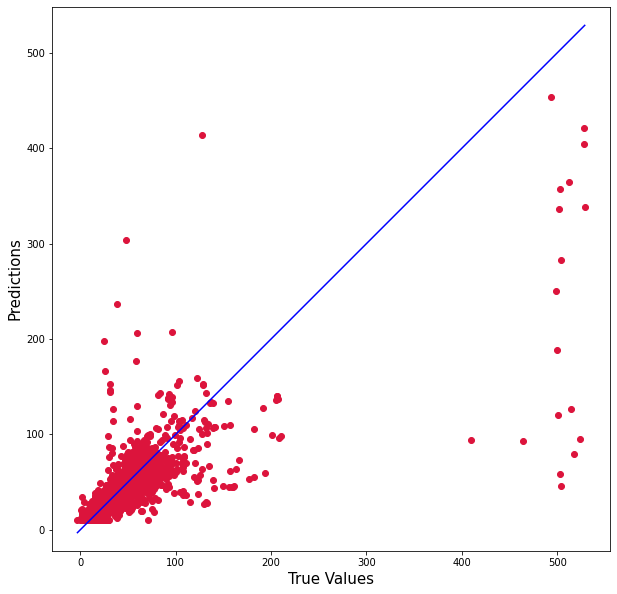

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(pred, y_test, c='crimson')

p1 = max(max(res_df.pred_scale), max(res_df.actual_scale))
p2 = min(min(res_df.pred_scale), min(res_df.actual_scale))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
df_train = pd.read_csv('datasets/iou1_train.csv')
df_valid = pd.read_csv('datasets/iou1_valid.csv')
df_test = pd.read_csv('datasets/iou1_test.csv')

In [ ]:
train = df_train.drop(['filename', 'class', 'weather', 'angle', 'depth_min', 'depth_max', 'depth_median'], axis=1)
valid = df_valid.drop(['filename', 'class', 'weather', 'angle', 'depth_min', 'depth_max', 'depth_median'], axis=1)
test = df_test.drop(['filename', 'class', 'weather', 'angle', 'depth_min', 'depth_max', 'depth_median'], axis=1)

In [ ]:
X_train = train.loc[:, train.columns != 'zloc']
y_train = train.loc[:, train.columns == 'zloc']

X_valid = valid.loc[:, valid.columns != 'zloc']
y_valid = valid.loc[:, valid.columns == 'zloc']

X_test = test.loc[:, test.columns != 'zloc']
y_test = test.loc[:, test.columns == 'zloc']

In [ ]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
#scalery = StandardScaler().fit(y_train)

In [ ]:
X_train_scale = scalerX.transform(X_train)
X_valid_scale = scalerX.transform(X_valid)
X_test_scale = scalerX.transform(X_test)

In [ ]:
# onehot encoding
class_dummy = pd.get_dummies(df_train['class'])
X_train = pd.concat([pd.DataFrame(X_train_scale), class_dummy], axis=1)
class_dummy = pd.get_dummies(df_valid['class'])
X_valid = pd.concat([pd.DataFrame(X_valid_scale), class_dummy], axis=1)
class_dummy = pd.get_dummies(df_test['class'])
X_test = pd.concat([pd.DataFrame(X_test_scale), class_dummy], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
#scalery = StandardScaler().fit(y_train)

In [ ]:
X_train = scalerX.transform(X_train)
X_valid = scalerX.transform(X_valid)
X_test = scalerX.transform(X_test)

In [ ]:
X_train

array([[ 0.29446261,  0.07797931,  0.06920307, ..., -0.35745166,
        -0.08387316, -0.15777241],
       [-0.20894158, -0.2374699 , -0.45723137, ..., -0.35745166,
        -0.08387316, -0.15777241],
       [-1.3743754 , -1.95593366, -0.7968392 , ..., -0.35745166,
        11.92276469, -0.15777241],
       ...,
       [-1.72875882,  1.61152393, -1.15209025, ..., -0.35745166,
        -0.08387316, -0.15777241],
       [ 1.18167324, -0.89421253,  0.87879041, ...,  2.79758106,
        -0.08387316, -0.15777241],
       [ 0.74510353, -0.37743429,  0.46311138, ..., -0.35745166,
        -0.08387316, -0.15777241]])